In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import asapy
import numpy as np
from time import time

# Cenário: Demonstração de Navegação com Aeronave de Caça

### Descrição Geral:
Este cenário descreve um voo de navegação realizado por uma aeronave de caça, enfocando a execução de manobras em diferentes altitudes e velocidades. A navegação abrange uma variação de altitude entre Flight Level (FL) 100 e FL 350, bem como uma variação de velocidade entre 350 knots e 550 knots. Durante este voo, no terceiro ponto da rota, a aeronave realizará uma manobra de espera em torno de um ponto específico (**Hold**) durante 10 minutos, integrando-a ao padrão de voo.

<img src='./data/nav_demo.gif' width='500' height='500'>

#### Carregando Dados das Simulações

Nesta célula, estamos carregando dados de diferentes simulações a partir de arquivos CSV. Para cada cenário, existem dois tipos de arquivos:

1. Arquivos `*_aliases.csv`: Estes contêm as entradas (ou parâmetros) para cada simulação.

2. Arquivos `*_output.csv`: Estes contêm os resultados das simulações. 

Os dados são lidos e carregados em DataFrames do pandas para análise e processamento subsequentes.


In [2]:
x = pd.read_csv('./data/nav_demo_aliases.csv')
y = pd.read_csv('./data/nav_demo_output.csv')

In [3]:
preprocessing  = asapy.Preprocessing()

x = preprocessing.aliases(x)
y = preprocessing.team_metrics(y)

In [4]:
df_nav = pd.merge(x, y[['fuel_consumed']], left_index=True, right_index=True)

In [5]:
sample_nav = df_nav.sample(10)
df_nav = df_nav.loc[~df_nav.index.isin(sample_nav.index)]

In [6]:
df_nav.head(5)

speed  altitude  fuel_consumed
experiment                                 
0           485.10  13339.30    1460.593196
1           518.46  34516.34     883.070714
2           501.61  23487.75    1063.105283
3           525.65  16748.43    1400.689116
4           438.32  21489.87    1051.047824

In [7]:
_df_nav = df_nav.copy()

In [8]:
_df_nav["speed_without_mean"] = df_nav["speed"] - df_nav["speed"].mean()

In [9]:
_df_nav["altitude_without_mean"] = df_nav["altitude"] - df_nav["altitude"].mean()

In [10]:
_df_nav["speed_without_mean_div_std"] = (df_nav["speed"] - df_nav["speed"].mean()) / df_nav["speed"].std()

In [11]:
_df_nav["altitude_without_mean_div_std"] = (df_nav["altitude"] - df_nav["altitude"].mean()) / df_nav["altitude"].std()

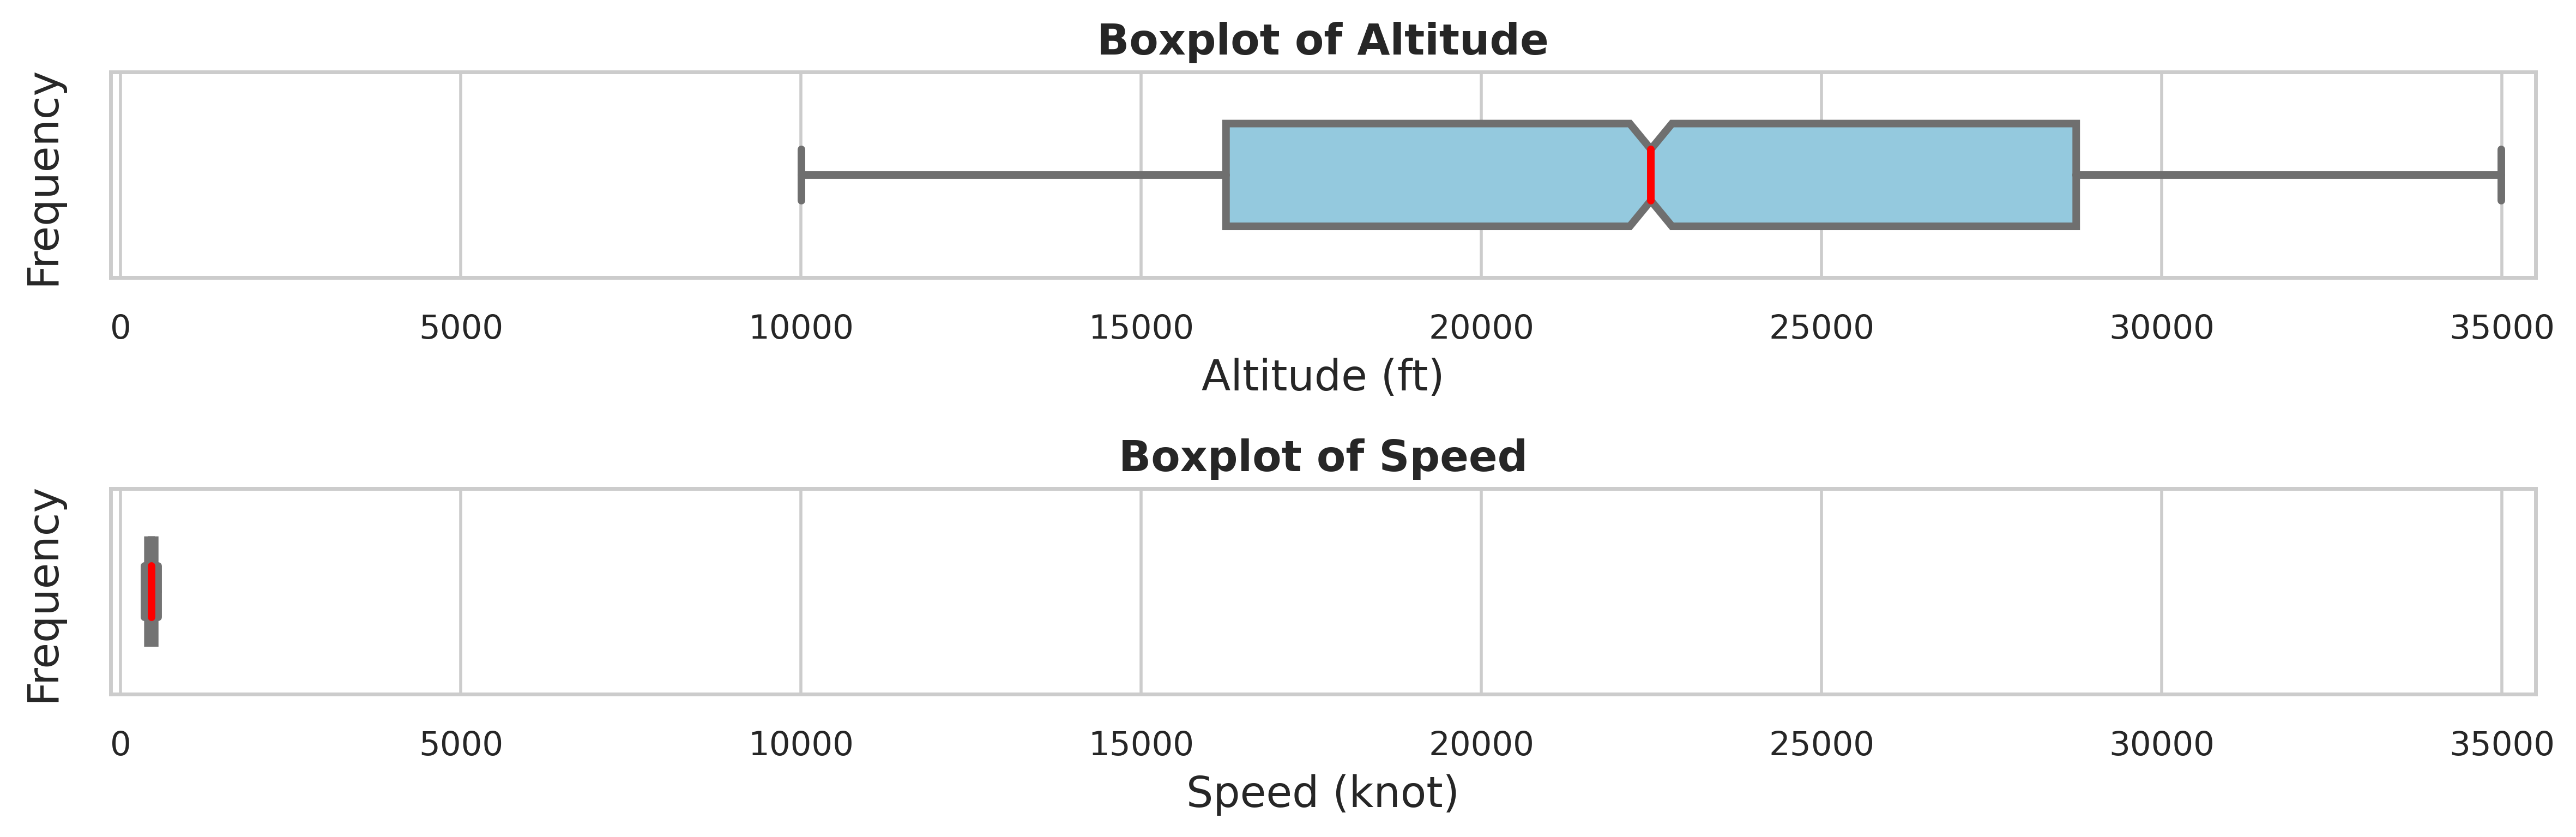

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definindo o estilo do gráfico
sns.set(style="whitegrid")

# Criando uma nova figura para os boxplots
plt.figure(figsize=(12, 4))

medianprops = dict(linestyle='-', linewidth=2.5, color='red')

min_value = min(_df_nav["speed"].min() - 500, _df_nav["altitude"].min() - 500)
max_value = max(_df_nav["speed"].max() + 500, _df_nav["altitude"].max() + 500)

# Criando o boxplot para altitude_without_mean_div_std
plt.subplot(2, 1, 1)  # 1 linha, 2 colunas, posição 2
sns.boxplot(x=_df_nav["altitude"], width=0.5, fliersize=5, linewidth=2.5, notch=True, color="skyblue", medianprops=medianprops)
plt.title('Boxplot of Altitude', fontsize=14, fontweight='bold')
plt.xlim(min_value, max_value)  # Definindo os mesmos limites para o eixo x
plt.xlabel("Altitude (ft)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Criando o boxplot para speed_without_mean_div_std
plt.subplot(2, 1, 2)  # 1 linha, 2 colunas, posição 1
sns.boxplot(x=_df_nav["speed"], width=0.5, fliersize=5, linewidth=2.5, notch=True, color="lightgreen", medianprops=medianprops)
plt.title('Boxplot of Speed', fontsize=14, fontweight='bold')
plt.xlim(min_value, max_value)  # Definindo os mesmos limites para o eixo x
plt.xlabel("Speed (knot)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Mostrando o gráfico
plt.tight_layout()

plt.savefig('boxplot1.png')
plt.show()

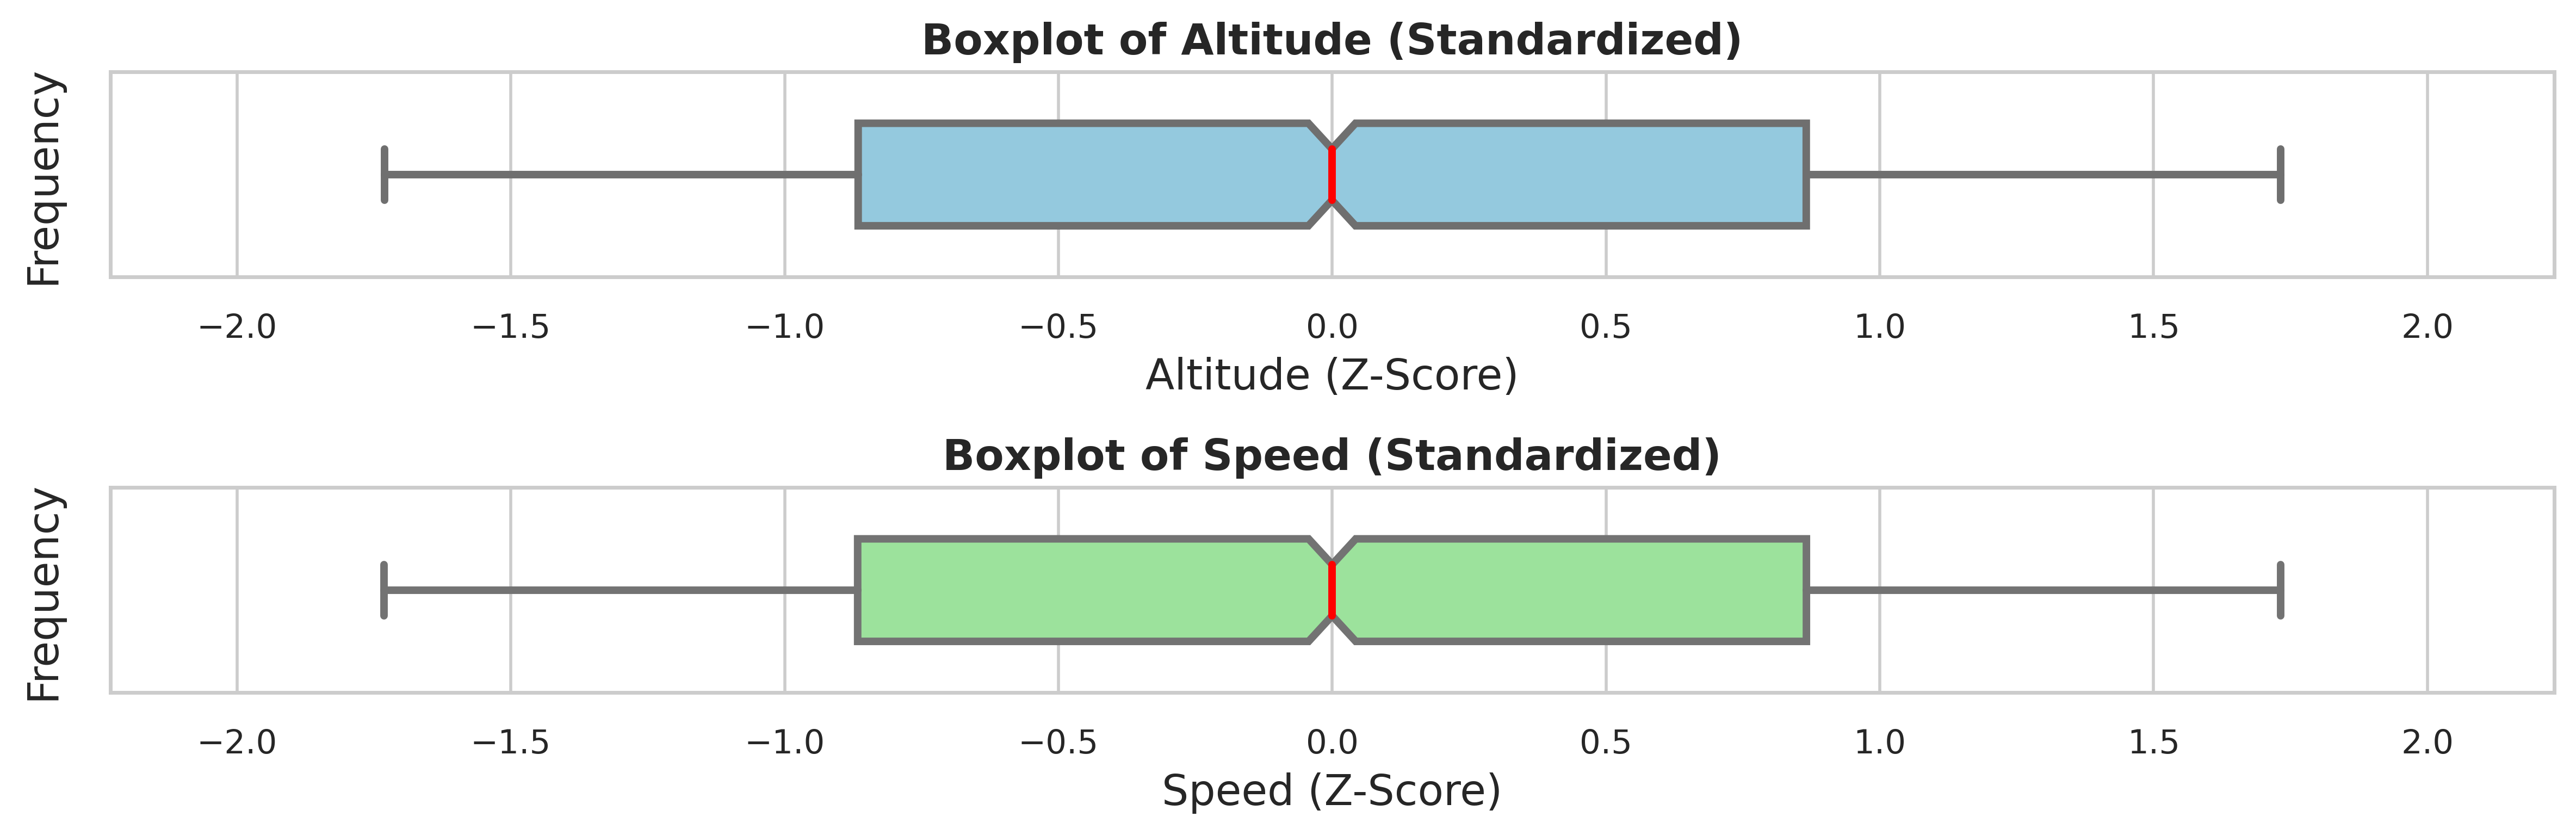

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definindo o estilo do gráfico
# sns.set(style="whitegrid")

# Criando uma nova figura para os boxplots
plt.figure(figsize=(12, 4))

medianprops = dict(linestyle='-', linewidth=2.5, color='red')

min_value = min(_df_nav["speed_without_mean_div_std"].min() - 0.5, _df_nav["altitude_without_mean_div_std"].min() - 0.5)
max_value = max(_df_nav["speed_without_mean_div_std"].max() + 0.5, _df_nav["altitude_without_mean_div_std"].max() + 0.5)

# Criando o boxplot para altitude_without_mean_div_std
plt.subplot(2, 1, 1)  # 1 linha, 2 colunas, posição 2
sns.boxplot(x=_df_nav["altitude_without_mean_div_std"], width=0.5, fliersize=5, linewidth=2.5, notch=True, color="skyblue", medianprops=medianprops)
plt.title('Boxplot of Altitude (Standardized)', fontsize=14, fontweight='bold')
plt.xlim(min_value, max_value)  # Definindo os mesmos limites para o eixo x
plt.xlabel("Altitude (Z-Score)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Criando o boxplot para speed_without_mean_div_std
plt.subplot(2, 1, 2)  # 1 linha, 2 colunas, posição 1
sns.boxplot(x=_df_nav["speed_without_mean_div_std"], width=0.5, fliersize=5, linewidth=2.5, notch=True, color="lightgreen", medianprops=medianprops)
plt.title('Boxplot of Speed (Standardized)', fontsize=14, fontweight='bold')
plt.xlim(min_value, max_value)  # Definindo os mesmos limites para o eixo x
plt.xlabel("Speed (Z-Score)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Mostrando o gráfico
plt.tight_layout()
plt.savefig('boxplot2.png')
plt.show()

## EXPERIMENTO 1: Previsão do Consumo de Combustível na rota específica

#### Rede Neural

In [14]:
start_time_1 = time()

In [15]:
nn_nav = asapy.NeuralNetwork(target="fuel_consumed", name='demo_nn_nav', seed=25)

In [16]:
nn_nav.build(
    df_nav,
    task="regression",
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    patience_reduceLR = 4,
    metrics=['rmse']
)


                Task: regression

                Total of registers: 3990
                Total of valid registers: 3990
                Total of invalid registers: 0

                Total of training registers: 2792
                Total of validation registers: 599
                Total of test registers: 599

                Features before preprocessing: 2
                Features after preprocessing: 2

                Numerical Features: ['speed', 'altitude']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['fuel_consumed']
            


In [17]:
nn_nav.hyperparameter_optimization(
    n_trials=18,
    num_folds=4,
    info=True,
    search_space_dropout = [0.0, 0.5],
    search_space_layers = [2, 3, 4],
    search_space_batch_size = [32, 64, 128],
    search_space_optimizer = ['Adam']
)

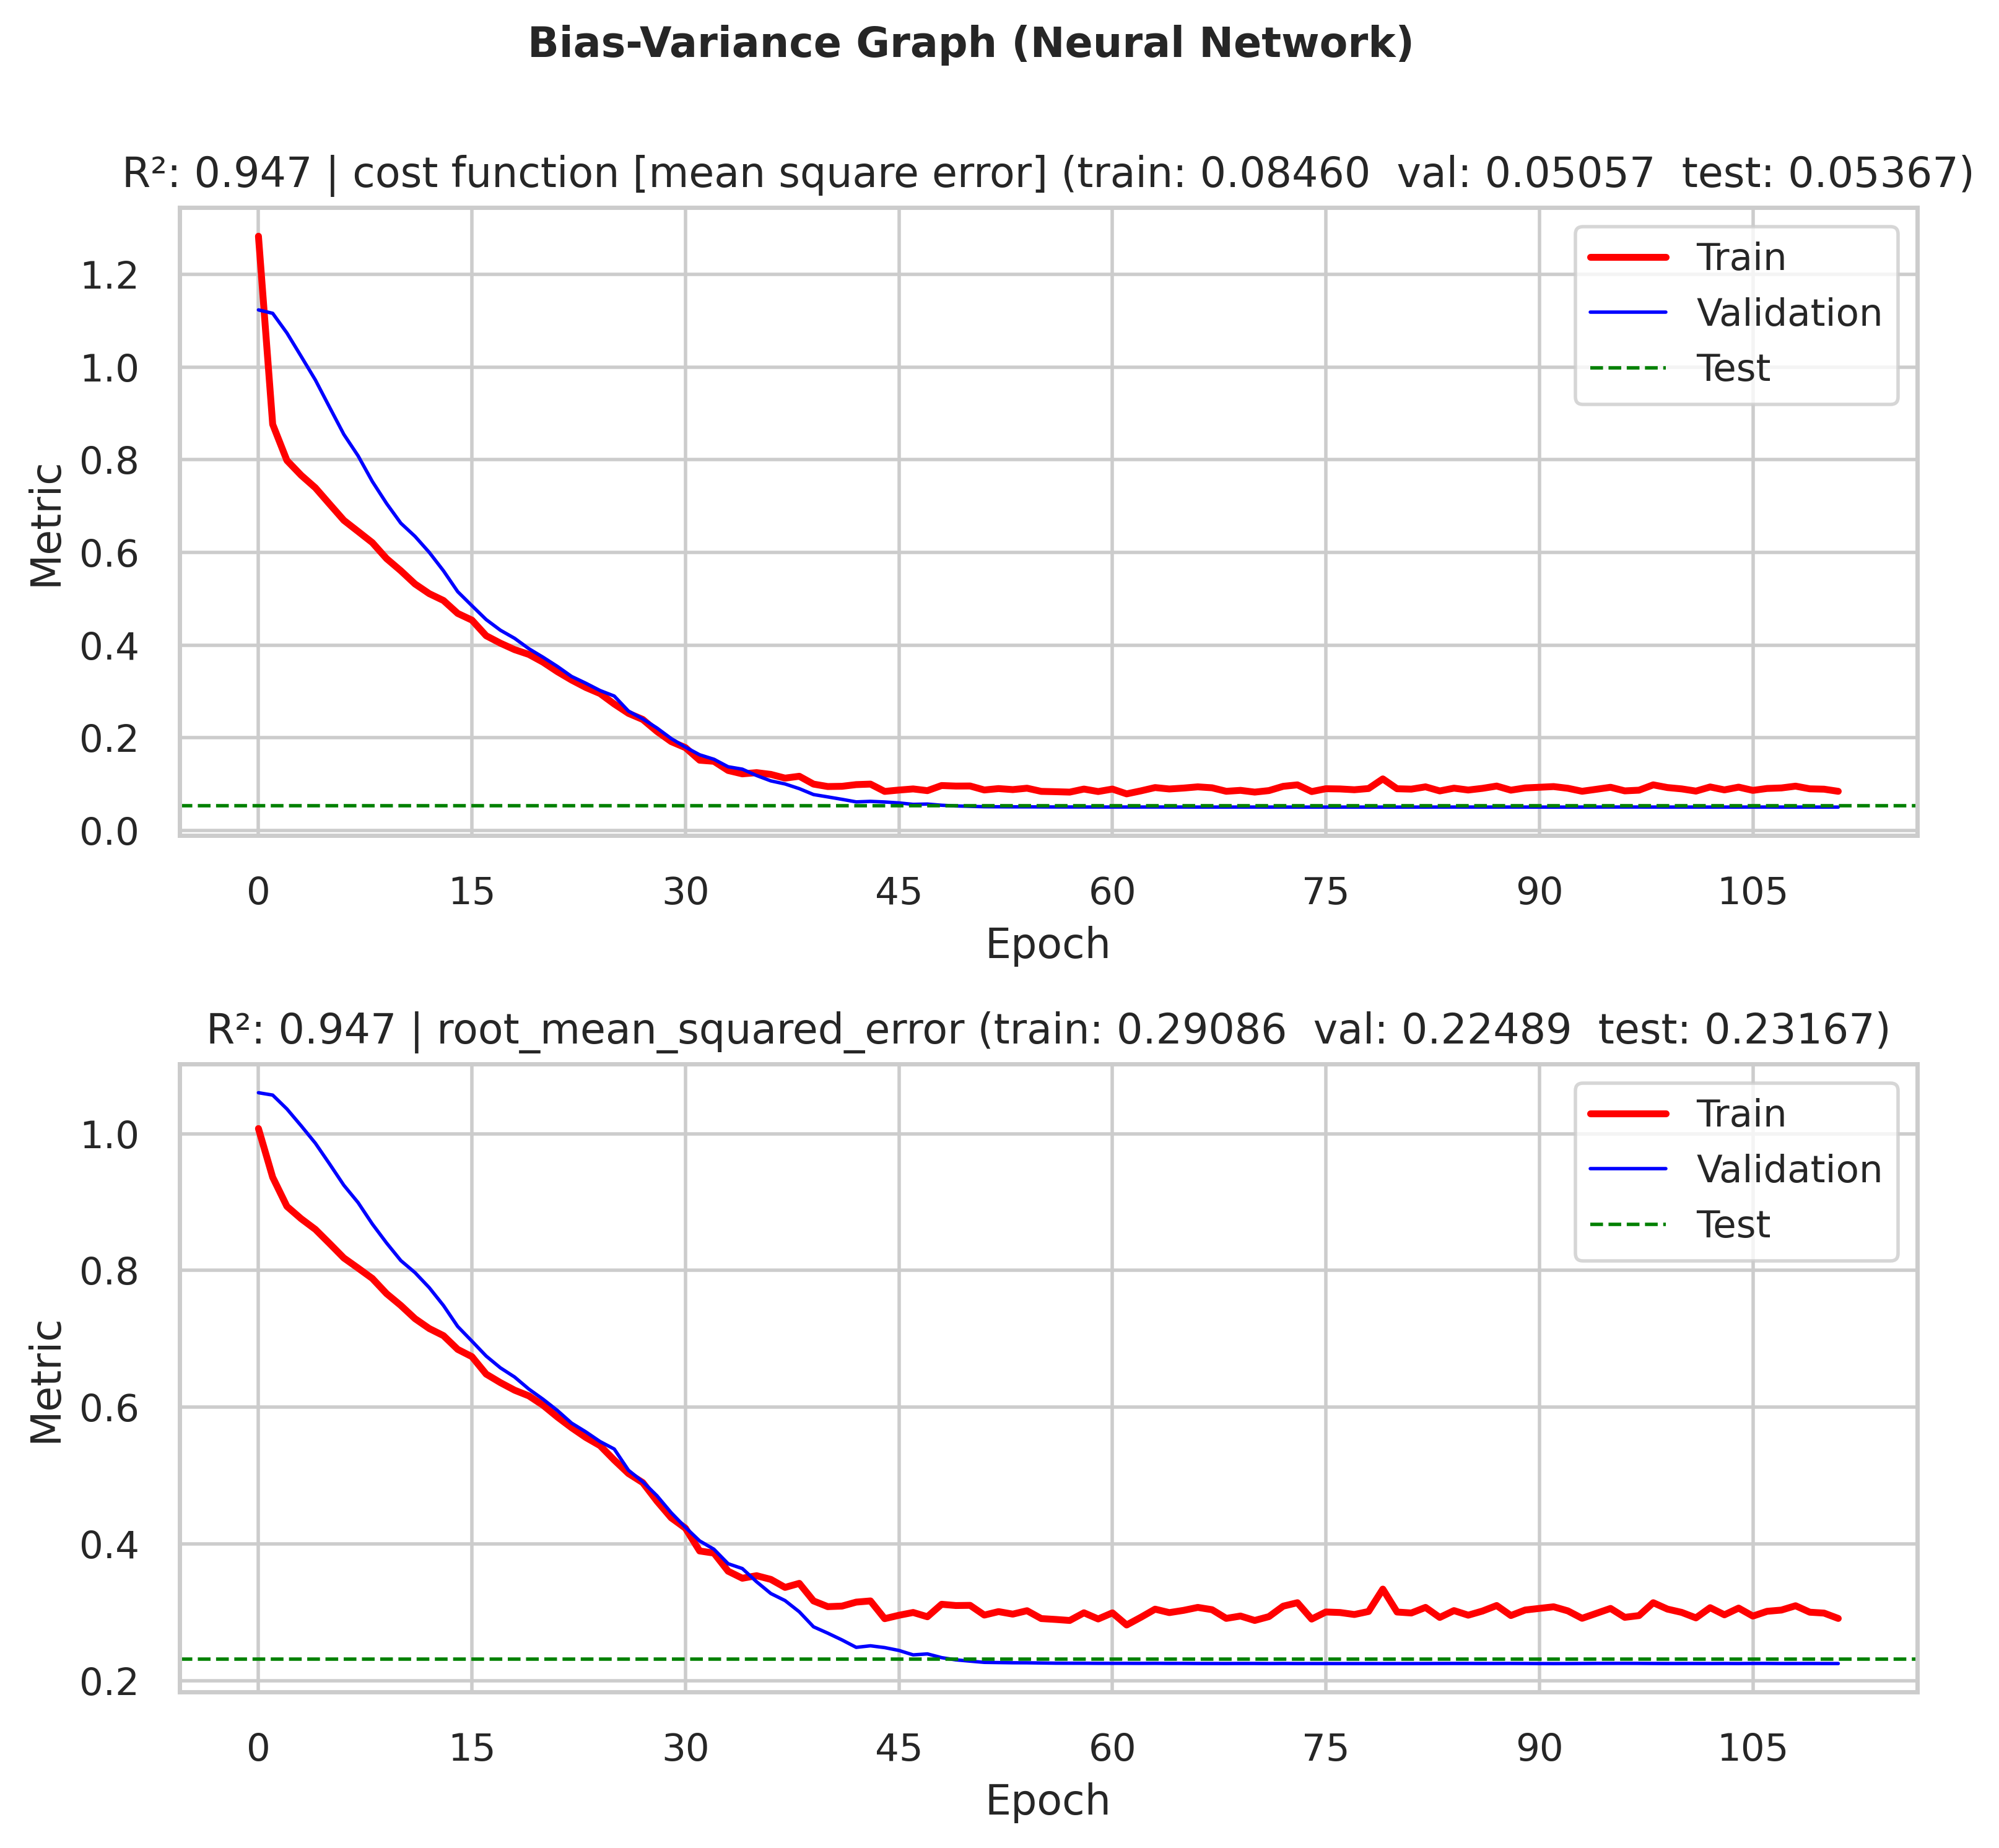

In [18]:
nn_nav.fit(return_history=False, graph=True, graph_save_extension='png', verbose=0)

In [19]:
end_time_1 = time()

In [20]:
start_time_2 = time()

In [21]:
pred_nn_nav = nn_nav.predict(sample_nav, verbose=0)

Inference time: 108.63 milliseconds (10 register(s))


In [22]:
pred_nn_nav

speed  altitude  fuel_consumed  fuel_consumed (NN prediction)
experiment                                                                
122         413.39  28947.33     960.719901                     976.384216
407         468.47  25614.55     974.028955                     976.384216
2460        407.78  24507.07    1003.369268                     976.384216
2055        532.31  13646.92    1594.487311                    1581.750488
3607        530.80  18248.14    1347.715681                    1376.035278
108         385.82  28387.47     978.215164                     976.384216
235         479.27  16127.56    1309.649280                    1305.435669
486         452.74  18271.88    1152.339282                    1127.769409
1749        354.52  34036.76    1138.099495                     976.384216
2621        431.47  33582.83     988.819101                     976.384216

In [23]:
end_time_2 = time()

In [24]:
print(f"Tempo de Treinamento: {end_time_1 - start_time_1}")

Tempo de Treinamento: 1240.7102420330048


In [25]:
print(f"Tempo de Inferência: {end_time_2 - start_time_2}")

Tempo de Inferência: 0.2079319953918457


#### XG Boost

In [26]:
start_time_3 = time()

In [27]:
xgb_nav = asapy.XgBoost(target="fuel_consumed", name='demo_xgb_nav', seed=25)

In [28]:
xgb_nav.build(
    df_nav,
    task="regression",
    num_folds=5,
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    metrics=['mse']
)


                Task: regression

                Total of registers: 3990
                Total of valid registers: 3990
                Total of invalid registers: 0

                Total of training registers: 2792
                Total of validation registers: 599
                Total of test registers: 599

                Features before preprocessing: 2
                Features after preprocessing: 2

                Numerical Features: ['speed', 'altitude']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['fuel_consumed']
            


In [29]:
xgb_nav.hyperparameter_optimization(
    n_trials=10,
    num_folds = 5, 
    info=True,
    search_space_tree_method = ['auto'],
    search_space_booster = ['gbtree', 'gblinear', 'dart'],
    search_space_learning_rate = [0.3],
    search_space_min_split_loss = [0],
    search_space_max_depth = [6],
    search_space_min_child_weight = [1],
    search_space_max_delta_step = [0],
    search_space_subsample = [1],
    search_space_sampling_method = ['uniform'],
    search_space_colsample_bytree = [1],
    search_space_colsample_bylevel = [1],
    search_space_colsample_bynode = [1],
    search_space_reg_lambda = [1],
    search_space_reg_alpha = [0],
    search_space_scale_pos_weight = [1],
    search_space_grow_policy = ['depthwise'],
    search_space_max_leaves = [0],
    search_space_max_bin = [256],
    search_space_num_parallel_tree = [1]
)

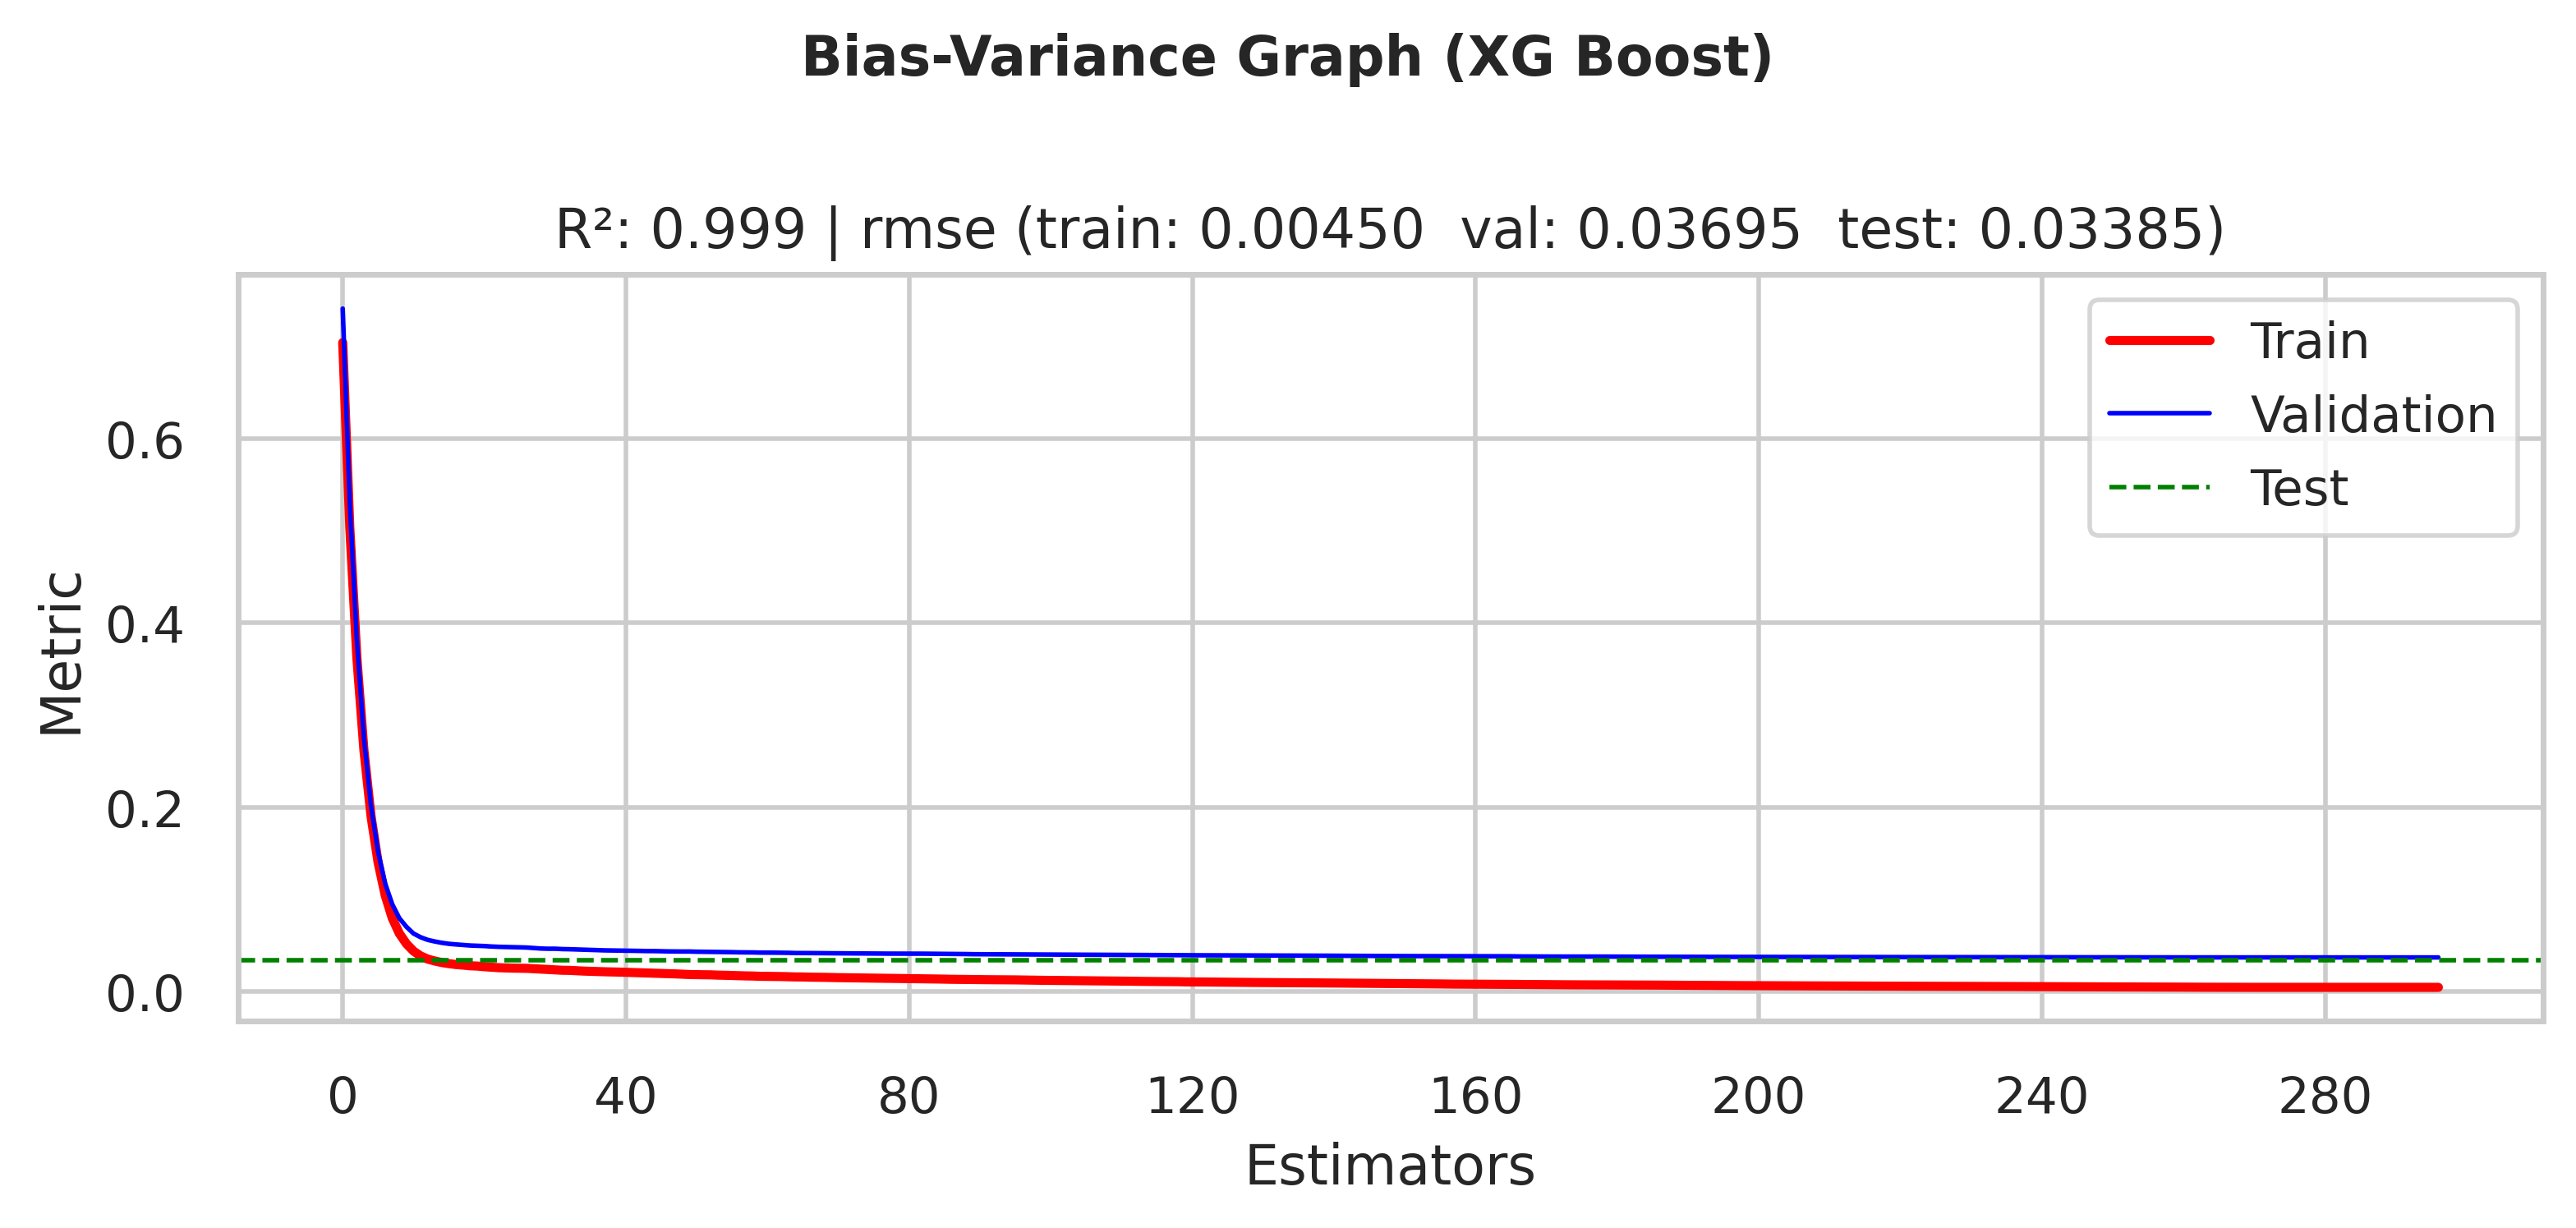

In [30]:
history_xgb_nav = xgb_nav.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [31]:
end_time_3 = time()

In [32]:
start_time_4 = time()

In [33]:
pred_xgb_nav = xgb_nav.predict(sample_nav)

Inference time: 31.19 milliseconds (10 register(s))


In [34]:
pred_xgb_nav

speed  altitude  fuel_consumed  fuel_consumed (XGB prediction)
experiment                                                                 
122         413.39  28947.33     960.719901                      958.892212
407         468.47  25614.55     974.028955                      978.449524
2460        407.78  24507.07    1003.369268                     1002.354919
2055        532.31  13646.92    1594.487311                     1597.253784
3607        530.80  18248.14    1347.715681                     1344.716309
108         385.82  28387.47     978.215164                      977.750732
235         479.27  16127.56    1309.649280                     1301.720825
486         452.74  18271.88    1152.339282                     1149.354980
1749        354.52  34036.76    1138.099495                     1135.420532
2621        431.47  33582.83     988.819101                      989.521301

In [35]:
end_time_4 = time()

In [36]:
print(f"Tempo de Treinamento: {end_time_3 - start_time_3}")

Tempo de Treinamento: 3606.853760242462


In [37]:
print(f"Tempo de Inferência: {end_time_4 - start_time_4}")

Tempo de Inferência: 0.10959506034851074


## EXPERIMENTO 2: Segmentação de classe de Combustível na rota específica

#### KMeans

In [38]:
start_time_5 = time()

In [39]:
kmeans_nav = asapy.KMeans(name='demo_kmeans_nav', seed=25)

In [40]:
kmeans_nav.build(df_nav, info=True)


                Total of registers: 3990
                Total of valid registers: 3990
                Total of invalid registers: 0

                Total of Features: 3
                Numerical Features: ['speed', 'altitude', 'fuel_consumed']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []
            


In [41]:
kmeans_nav.hyperparameter_optimization(
    n_trials=10,
    info=True,
    search_space_n_clusters=[4],
    search_space_init  = ['k-means++'],
    search_space_n_init = ['auto'],
    search_space_tol = [1e-5, 1e-4, 1e-3],
    search_space_algorithm = ['lloyd', 'elkan']
)

Trial (nº)  Silhouette Score params_algorithm params_init  \
Ranking                                                              
1º                1          0.394534            elkan   k-means++   
2º                3          0.394534            elkan   k-means++   
3º                5          0.394534            lloyd   k-means++   
4º                7          0.394534            lloyd   k-means++   
5º                0          0.394525            lloyd   k-means++   
6º                2          0.394525            elkan   k-means++   
7º                6          0.394525            elkan   k-means++   
8º                8          0.394525            lloyd   k-means++   
9º                4          0.394508            elkan   k-means++   
10º               9          0.394508            elkan   k-means++   

         params_n_clusters params_n_init  params_tol  
Ranking                                               
1º                       4          auto     0.00100  
2º                       4          auto     0.00100  
3º                       4          auto     0.00100  
4º                       4          auto     0.00100  
5º                       4          auto     0.00001  
6º                       4          auto     0.00001  
7º                       4          auto     0.00001  
8º                       4          auto     0.00001  
9º                       4          auto     0.00010  
10º                      4          auto     0.00010

In [42]:
clusters = kmeans_nav.fit(return_cluster=True)

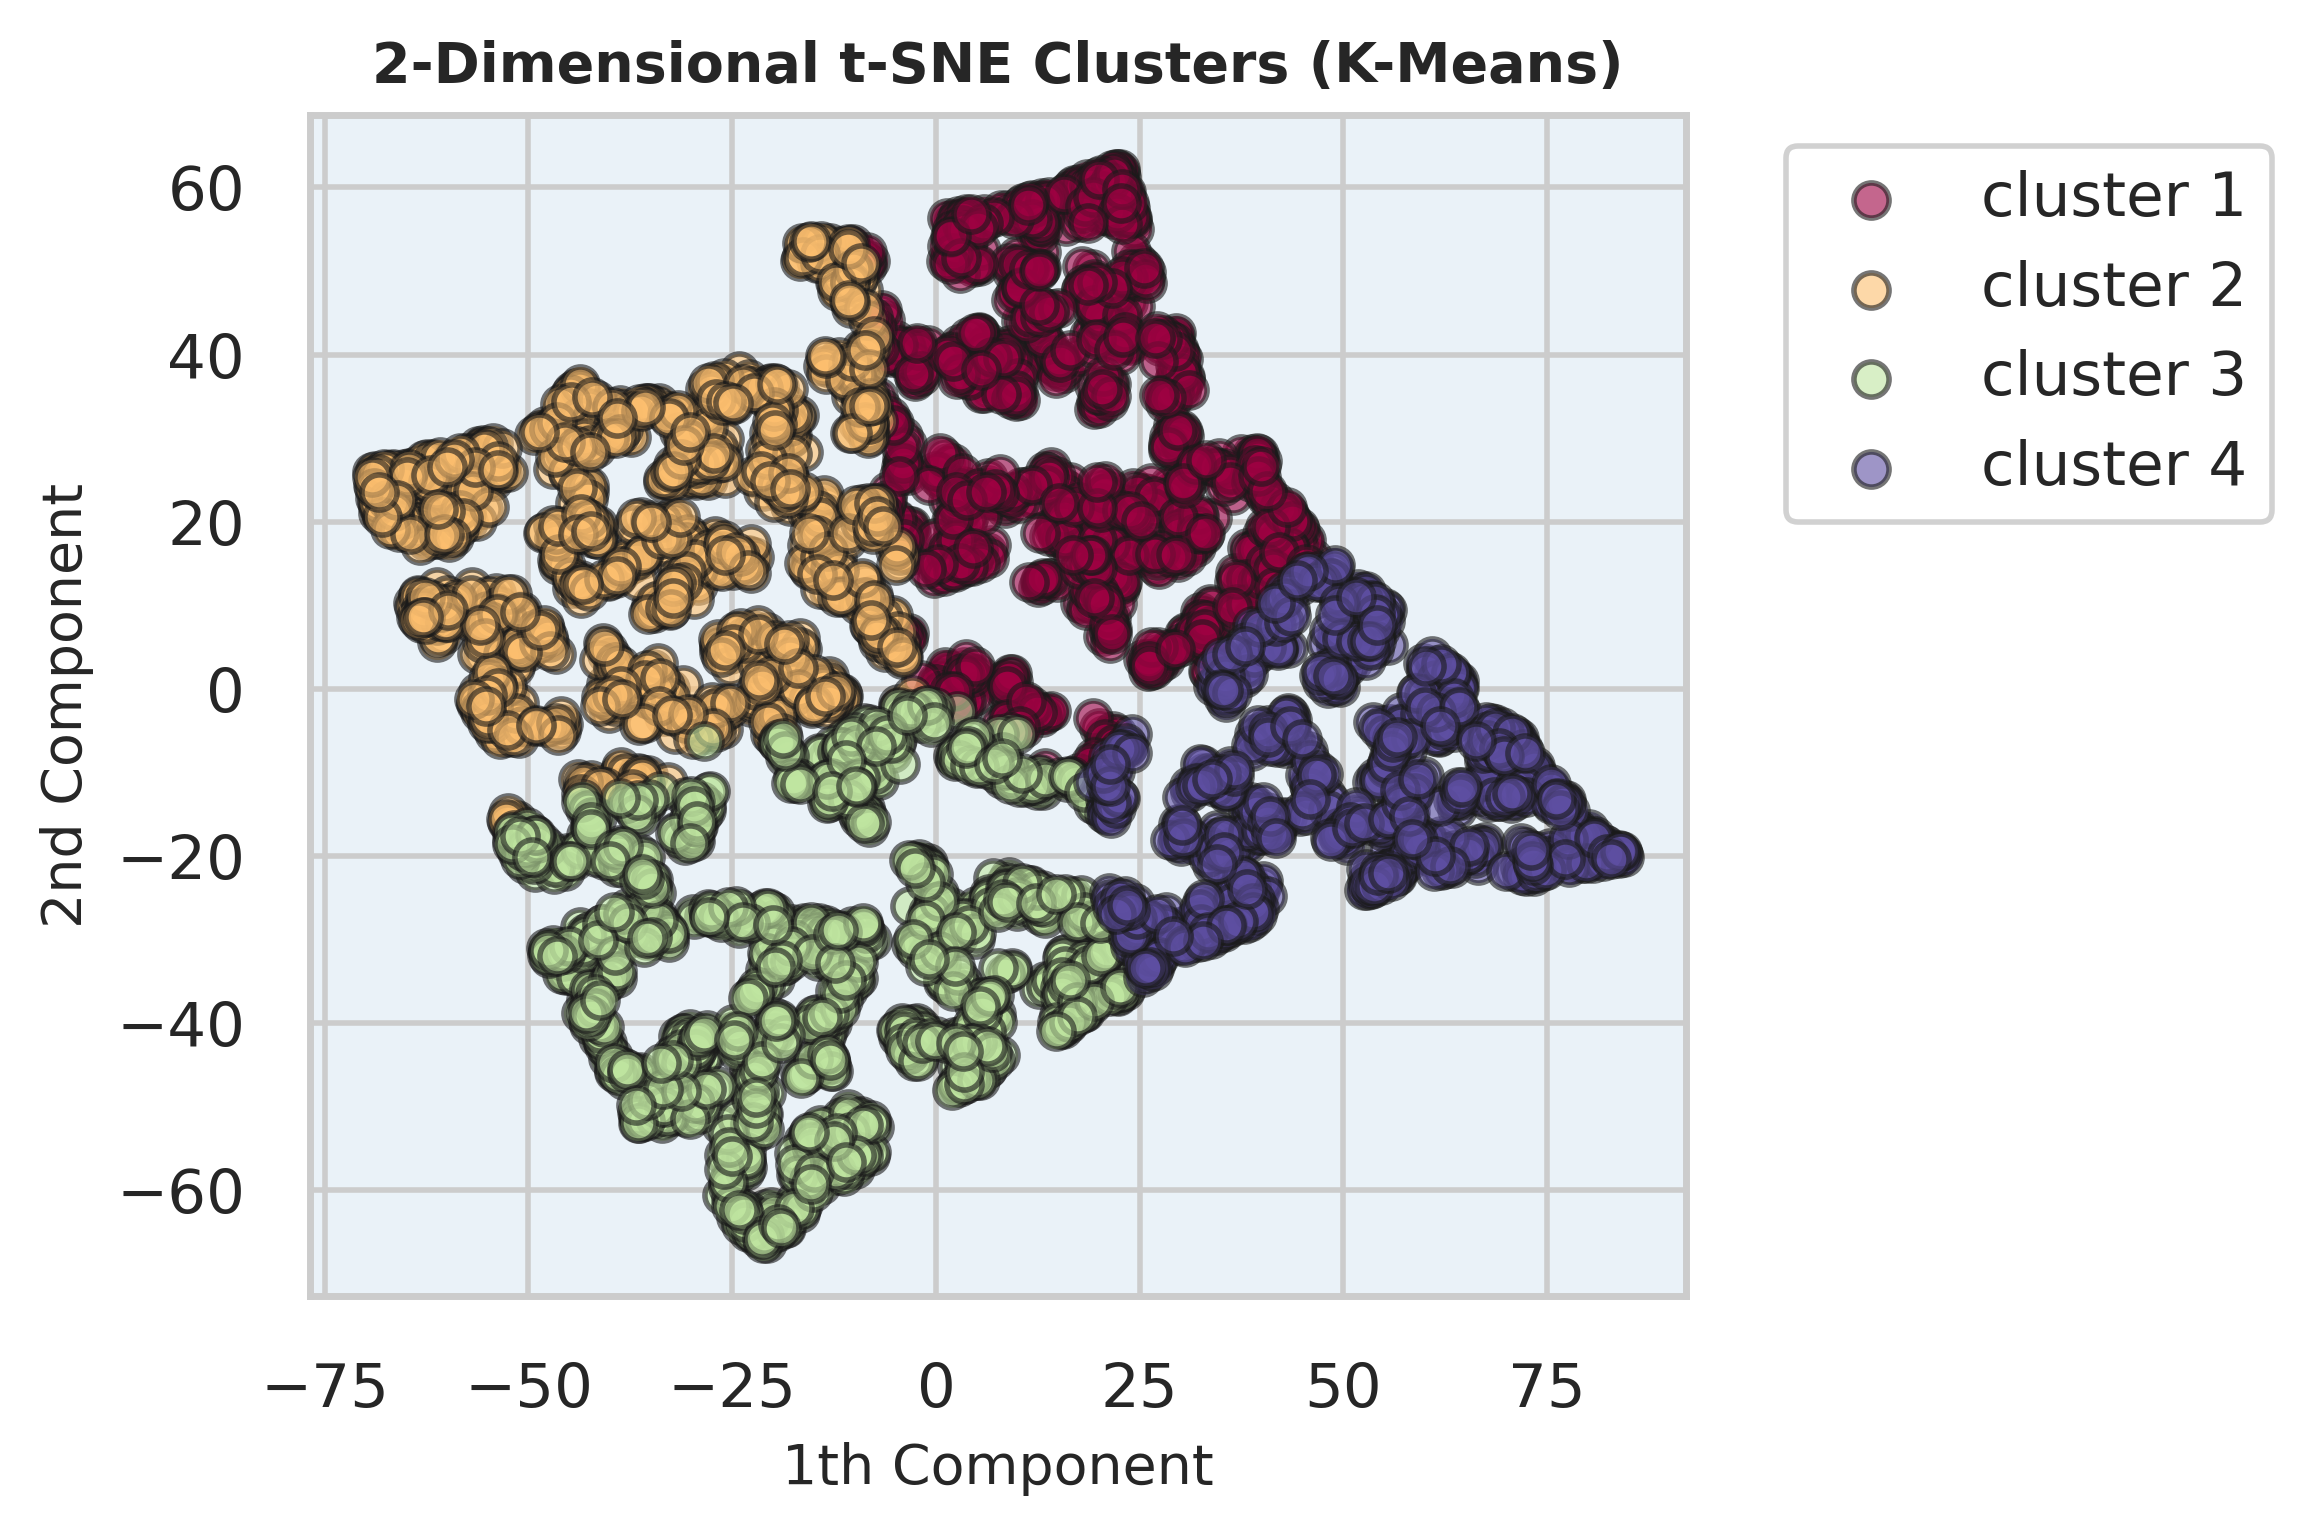

In [43]:
kmeans_nav.predict(projection='2d', graph_save_extension='png')

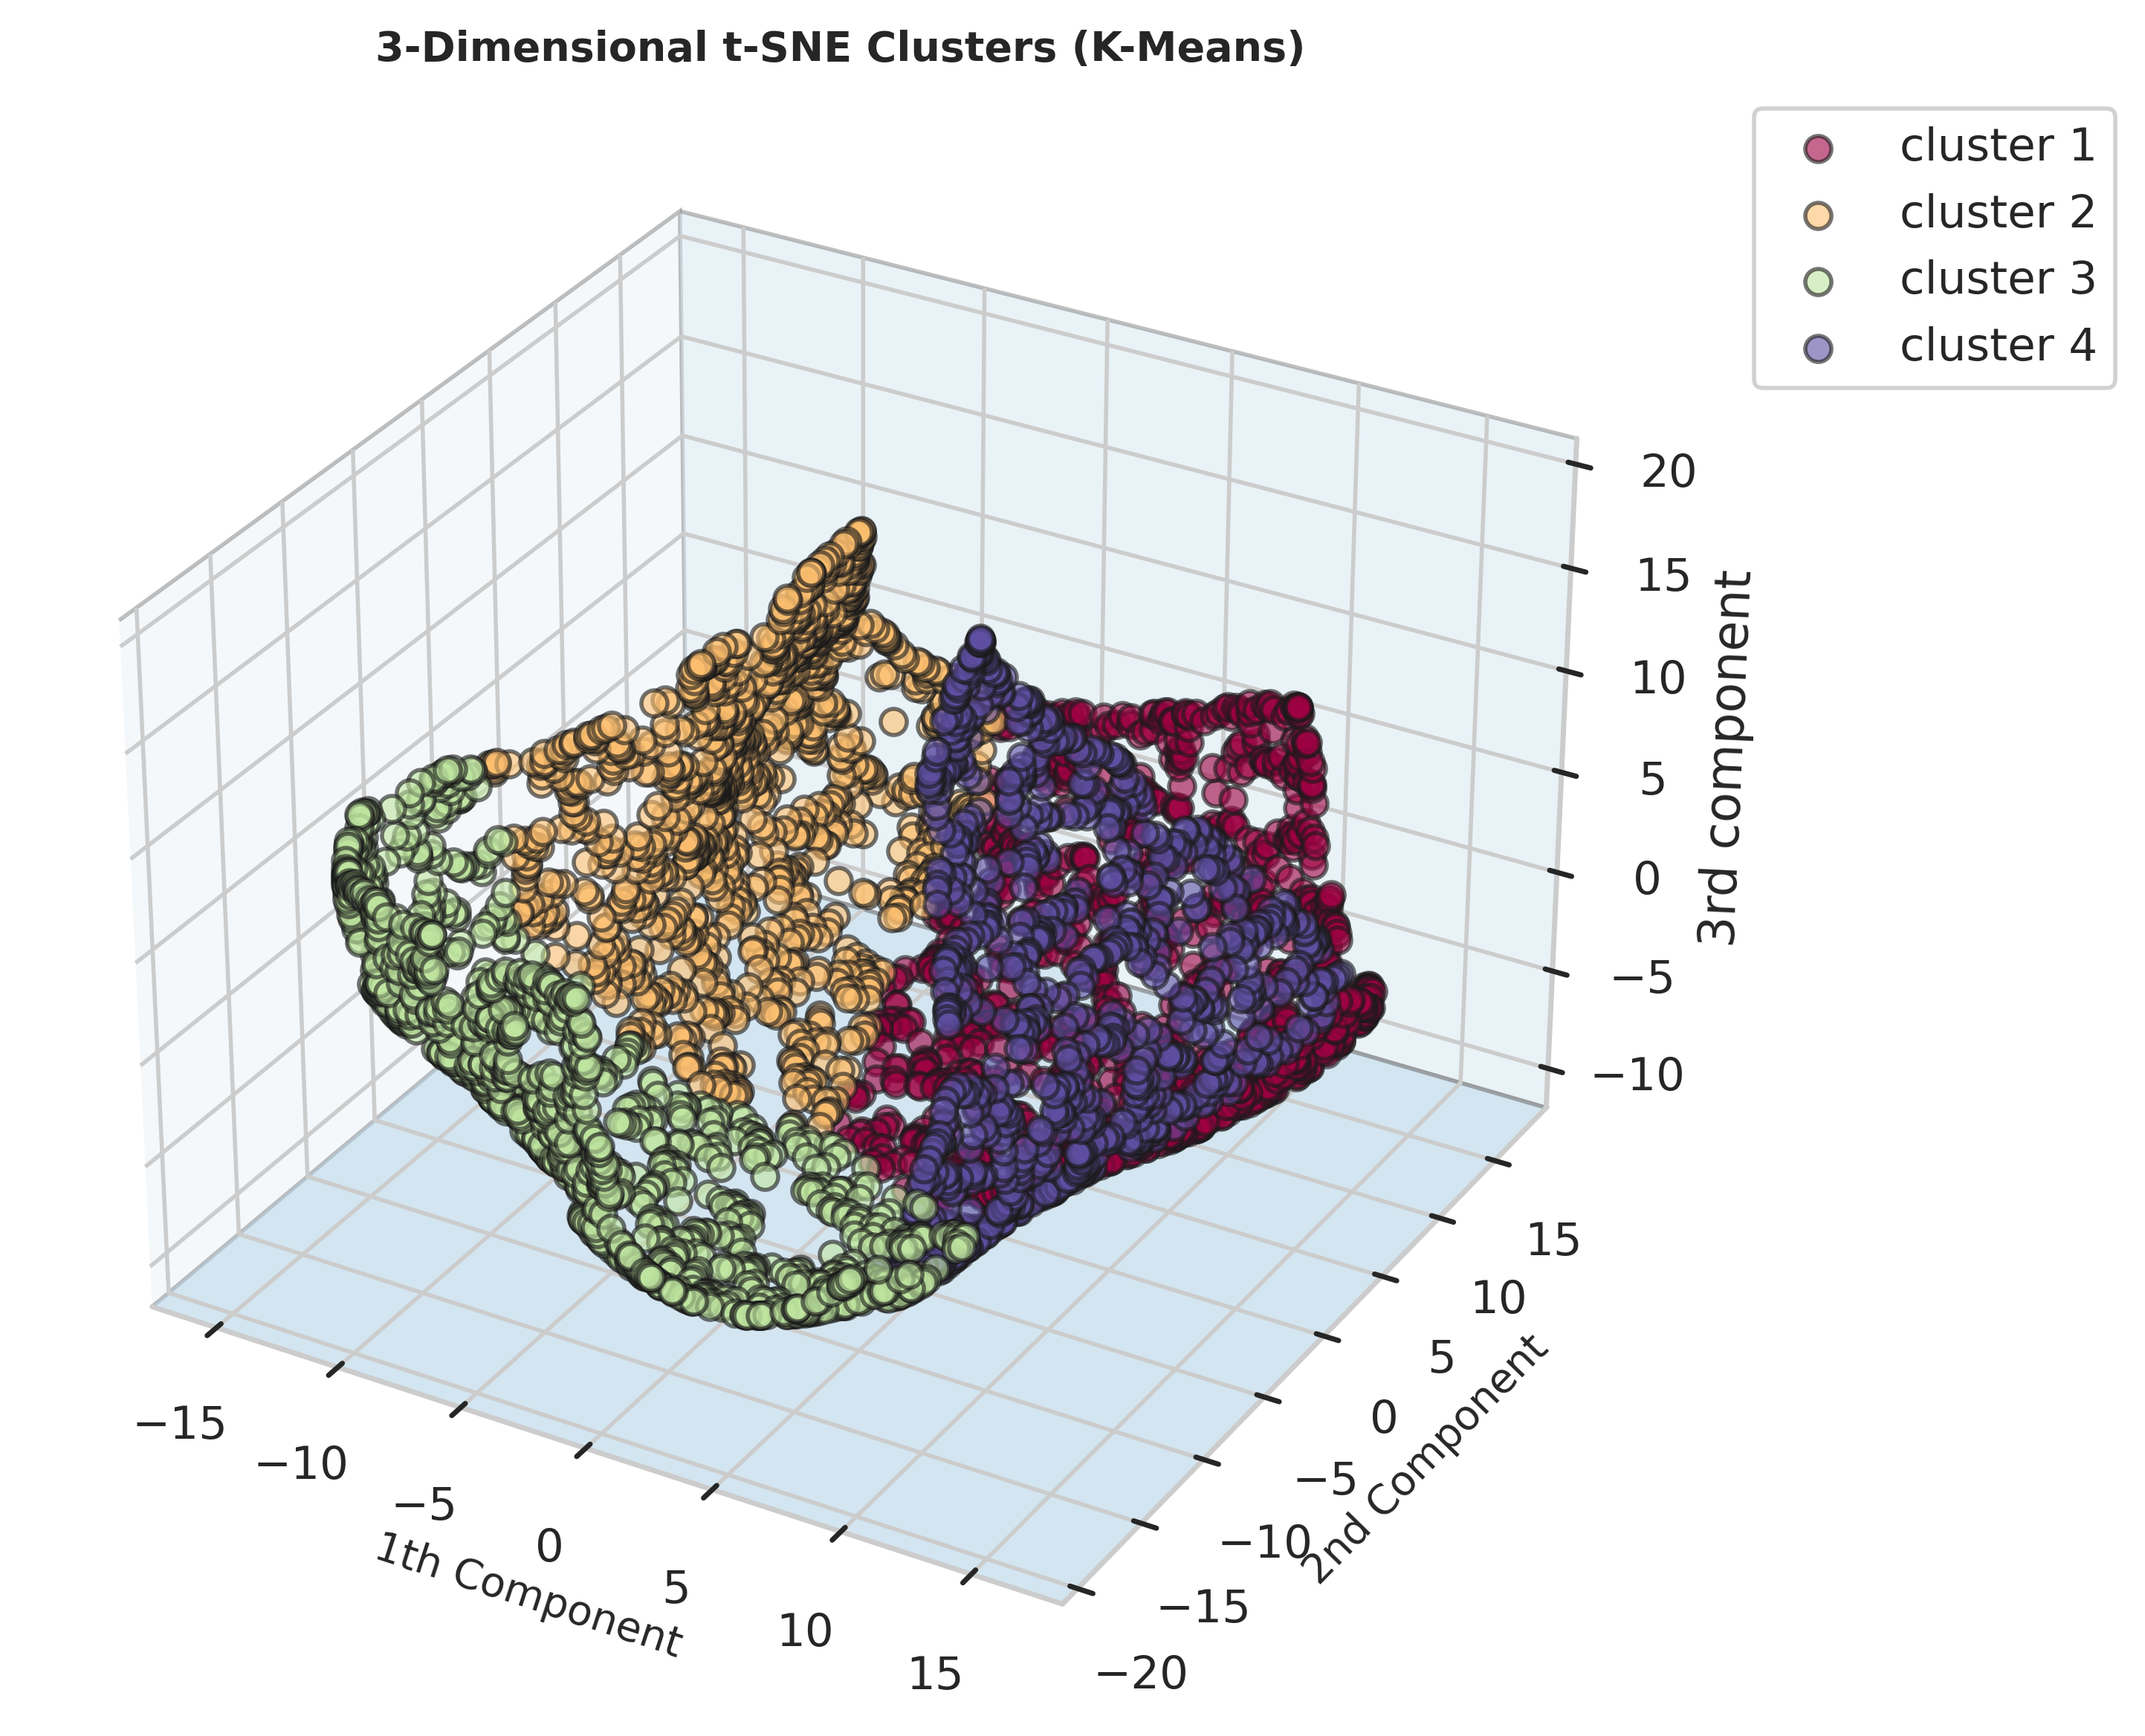

In [44]:
kmeans_nav.predict(projection='3d', graph_save_extension='png')

In [45]:
end_time_5 = time()

In [46]:
print(f"Tempo de Treinamento: {end_time_5 - start_time_5}")

Tempo de Treinamento: 53.25713920593262


## EXPERIMENTO 3: Previsão da classe de Consumo de Combustível na rota específica

#### Data leak intencional, com o intuito de criar um Case de classificação. Asuma que a nfomação do cluster seja obtida de observação factual

In [47]:
df_nav_class = df_nav.copy()
df_nav_class['Cluster'] = clusters

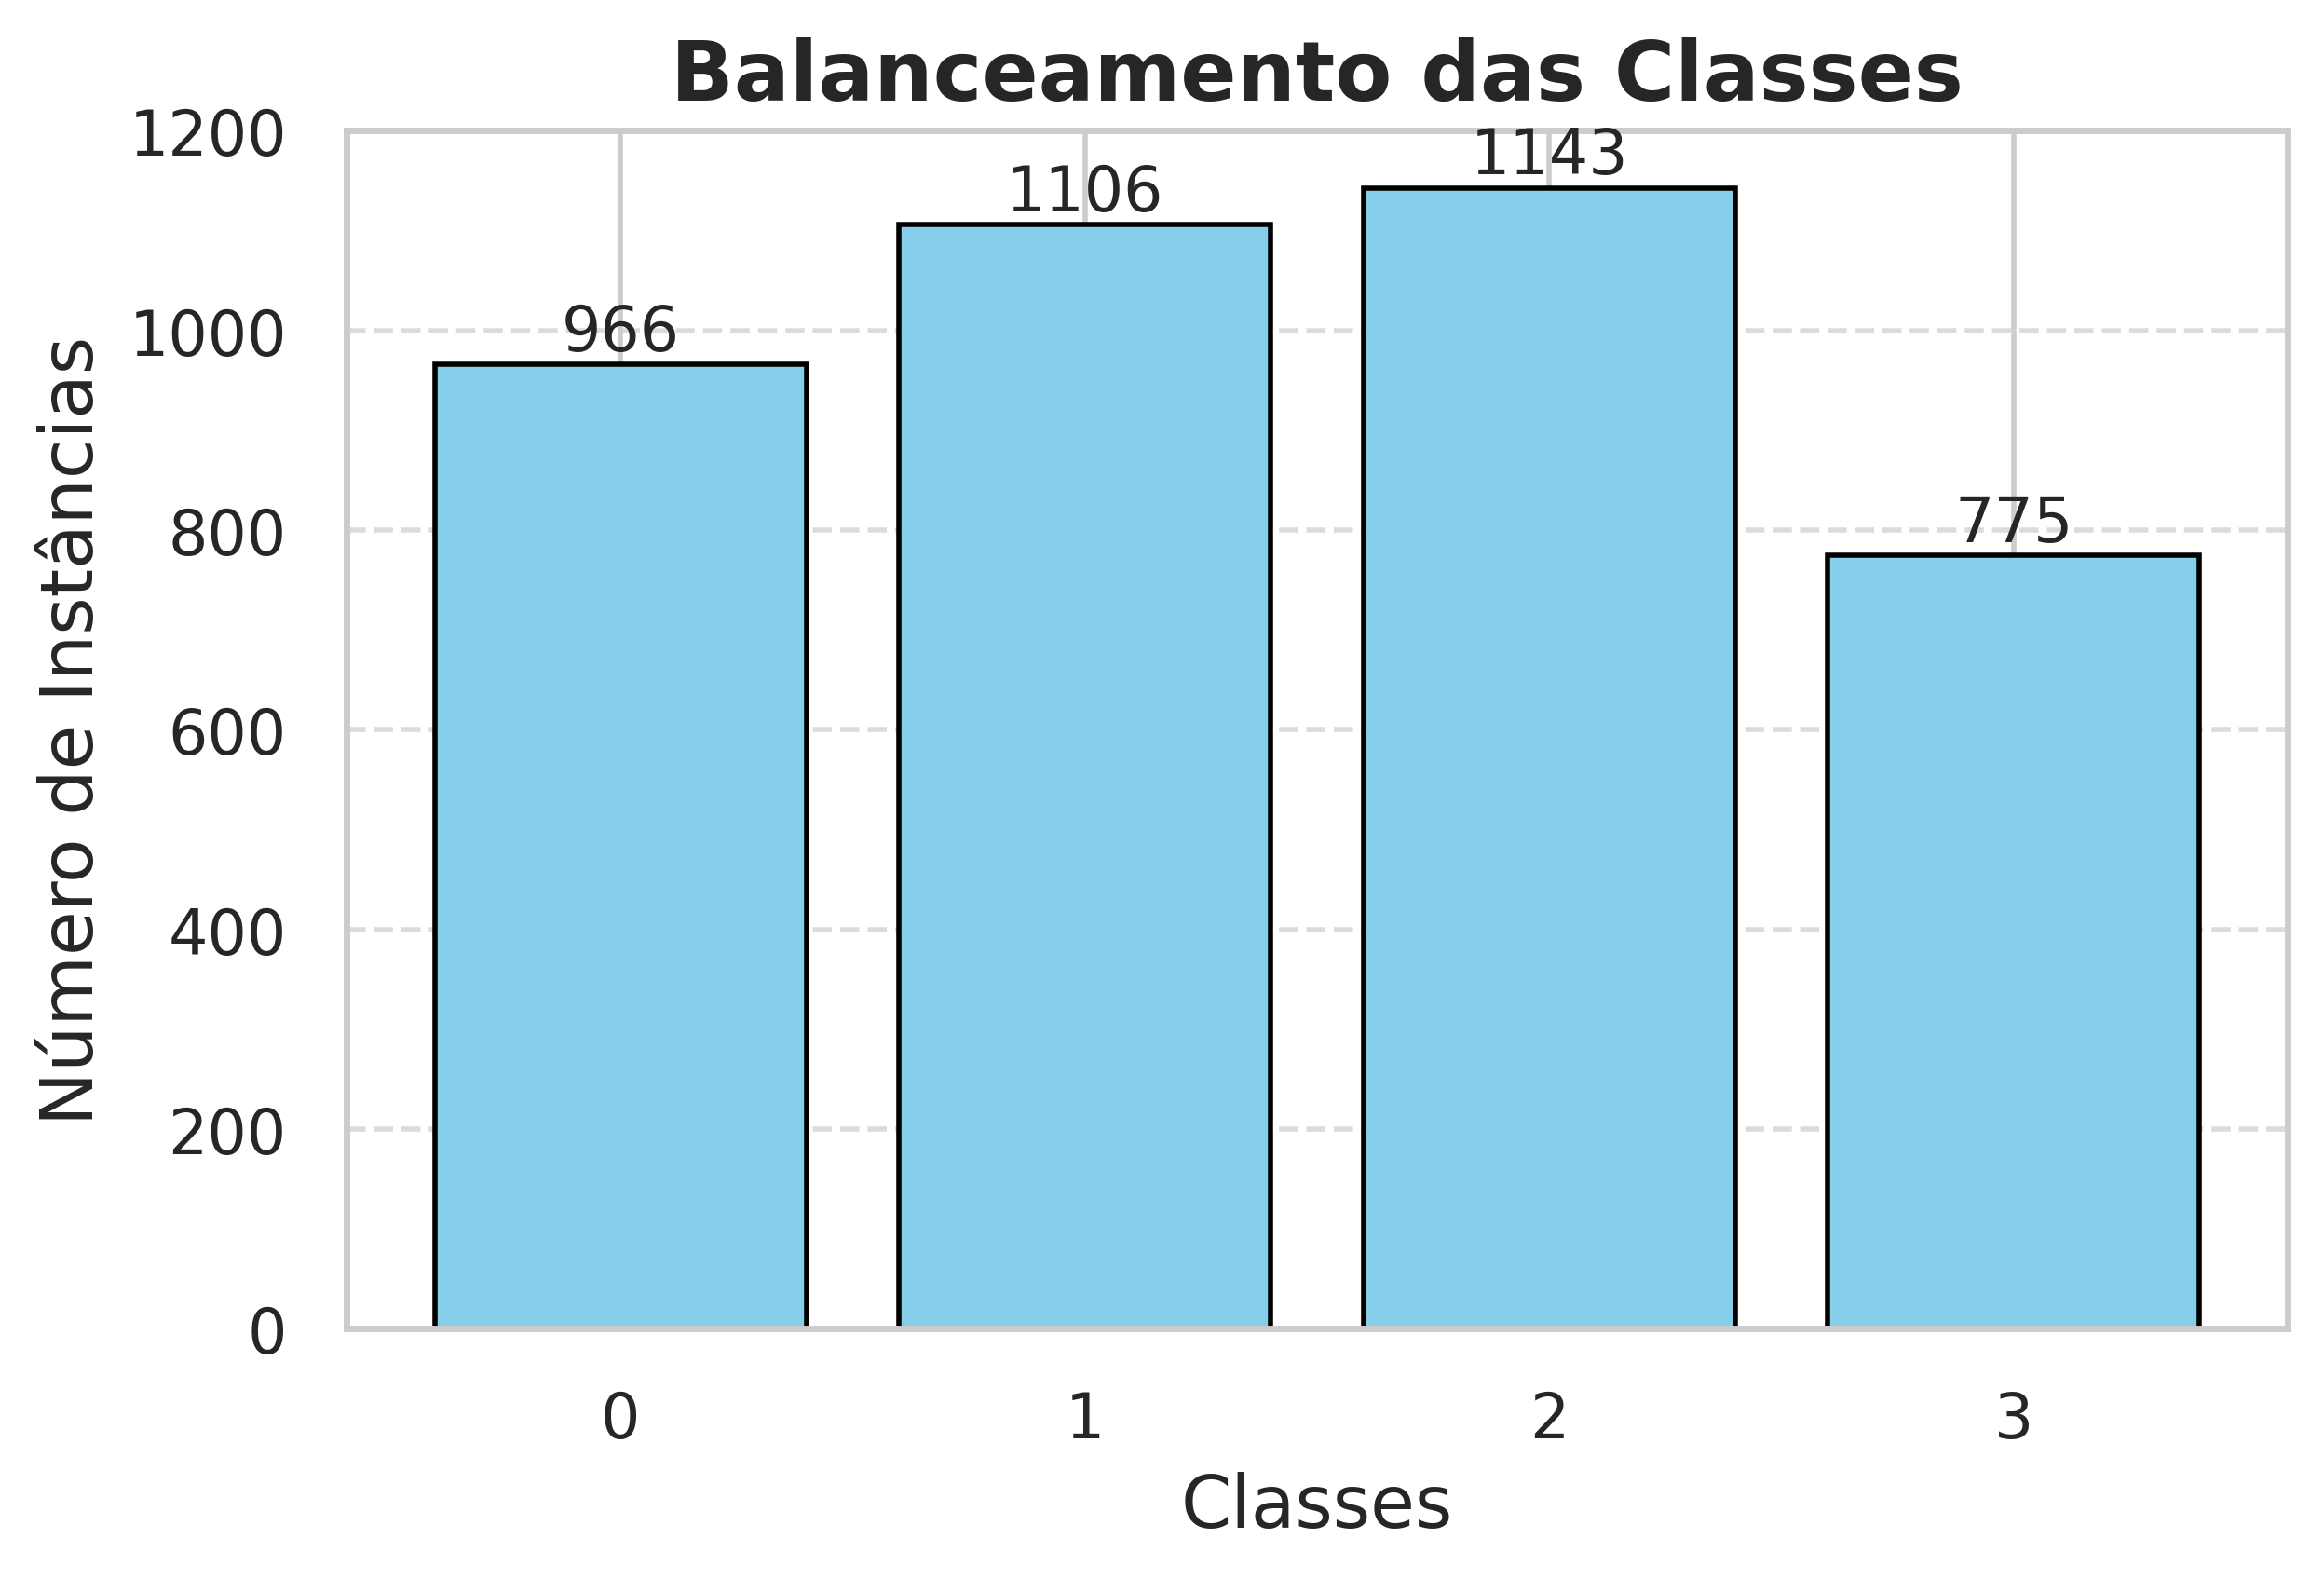

In [48]:
# plt.style.use('seaborn-darkgrid')  # Usa um estilo de fundo do Seaborn
# plt.figure(figsize=(10, 6))  # Tamanho do gráfico

class_counts = df_nav_class['Cluster'].value_counts().sort_index()

bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

plt.title('Balanceamento das Classes', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Número de Instâncias', fontsize=14)

plt.xticks(class_counts.index, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [49]:
# !pip install imblearn

In [50]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=42)
X = df_nav_class.drop('Cluster', axis=1)
y = df_nav_class['Cluster']

X_res, y_res = sm.fit_resample(X, y)

# Se precisar, converta de volta para DataFrame pandas
df_nav_class = pd.DataFrame(X_res, columns=X.columns)
df_nav_class['Cluster'] = y_res

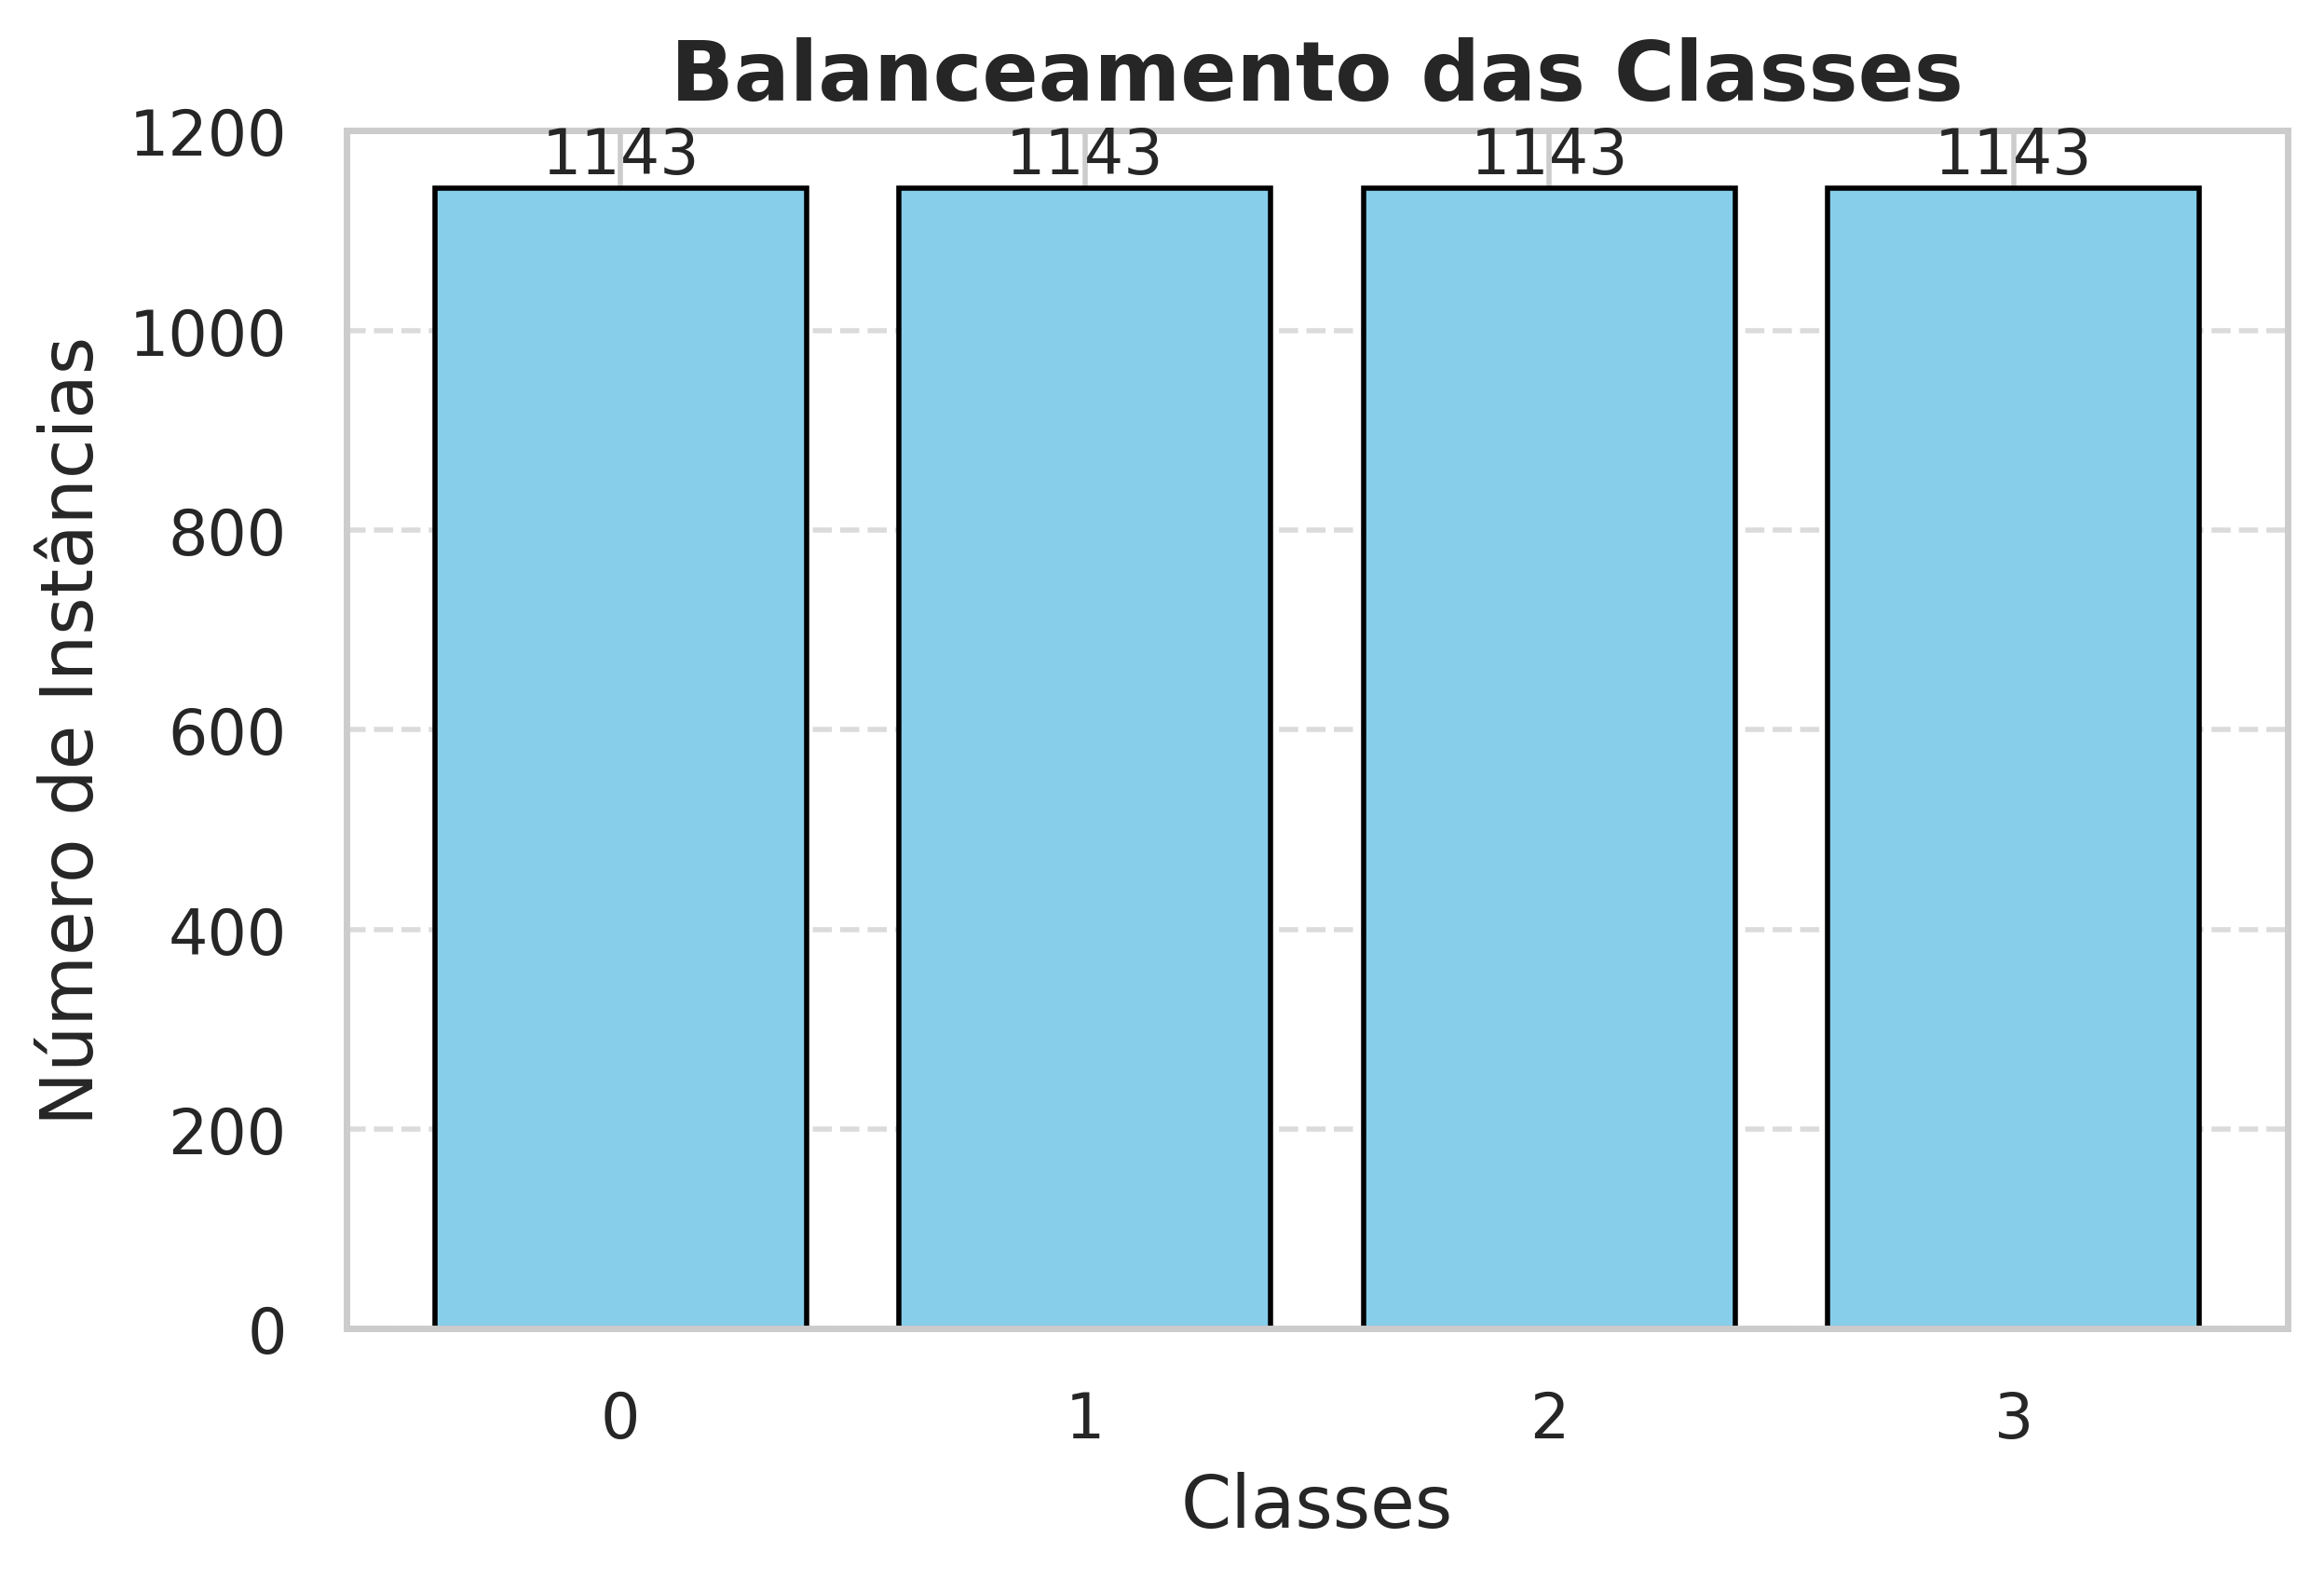

In [51]:
# plt.style.use('seaborn-darkgrid')  # Usa um estilo de fundo do Seaborn
# plt.figure(figsize=(10, 6))  # Tamanho do gráfico

class_counts = df_nav_class['Cluster'].value_counts().sort_index()

bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

plt.title('Balanceamento das Classes', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Número de Instâncias', fontsize=14)

plt.xticks(class_counts.index, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [52]:
sample_nav_class = df_nav_class.sample(10)
df_nav_class = df_nav_class.loc[~df_nav_class.index.isin(sample_nav_class.index)]

#### Rede Neural

In [53]:
start_time_6 = time()

In [54]:
nn_nav_class = asapy.NeuralNetwork(target="Cluster", name='demo_nn_nav_class', seed=25)

In [55]:
nn_nav_class.build(
    df_nav_class,
    task='classification',
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    patience_reduceLR = 4,
    metrics=['auc', 'precision', 'recall', 'accuracy'] 
)


                Task: classification

                Total of registers: 4562
                Total of valid registers: 4562
                Total of invalid registers: 0

                Total of training registers: 3193
                Total of validation registers: 685
                Total of test registers: 684

                Features before preprocessing: 3
                Features after preprocessing: 3

                Numerical Features: ['speed', 'altitude', 'fuel_consumed']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['Cluster']
            	Cardinality (Target): 4


In [56]:
nn_nav_class.hyperparameter_optimization(
    n_trials=10,
    num_folds=5,
    info=True,
    search_space_dropout = [0.0, 0.5],
    search_space_layers = [2, 3, 4],
    search_space_batch_size = [32, 64],
    search_space_optimizer = ['Adam']
)

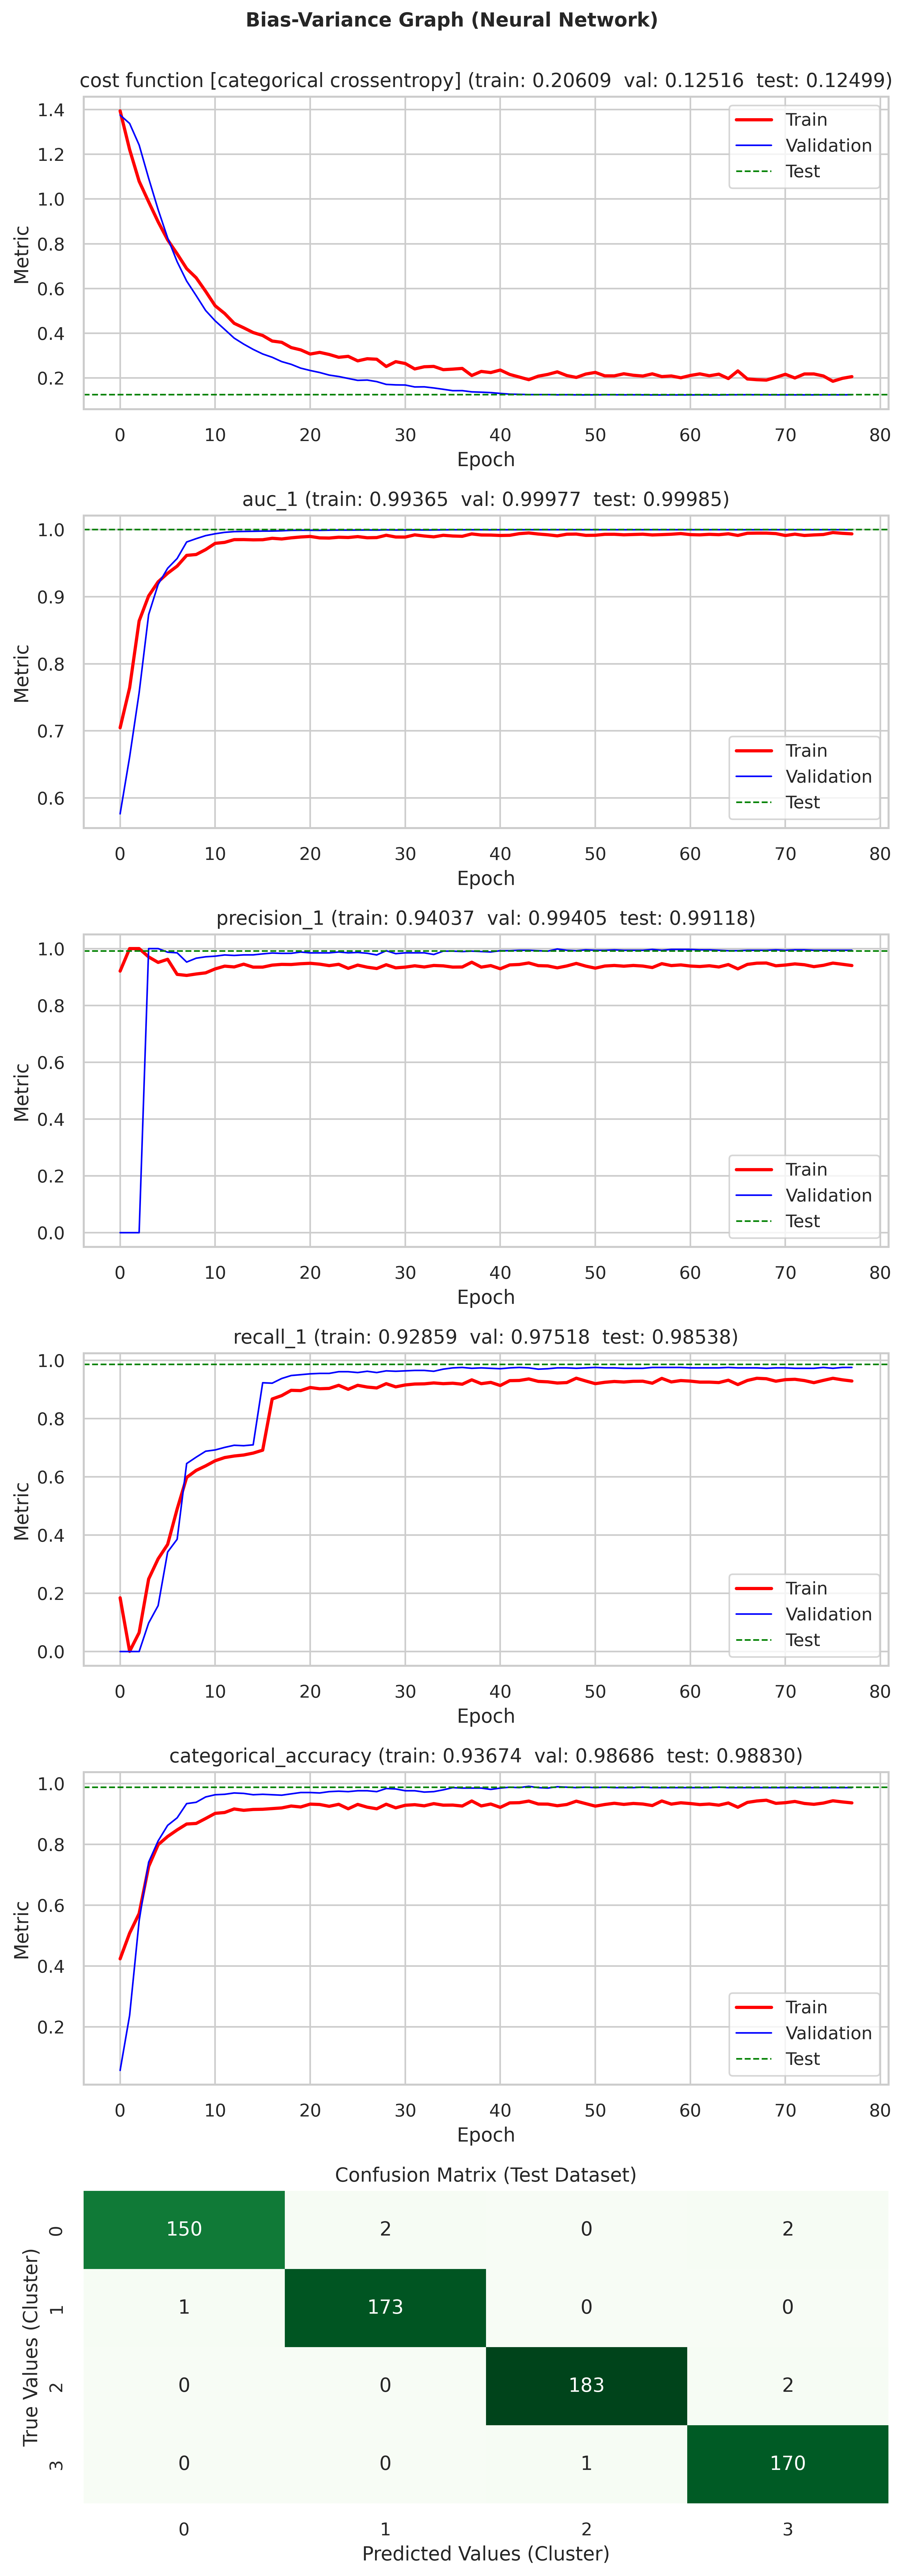

In [57]:
history_nn_nav_class = nn_nav_class.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [58]:
end_time_6 = time()

In [59]:
start_time_7 = time()

In [60]:
pred_nn_nav_class = nn_nav_class.predict(sample_nav_class, verbose=0)

Inference time: 71.57 milliseconds (10 register(s))


In [61]:
pred_nn_nav_class

speed      altitude  fuel_consumed  Cluster  \
1073  512.880000  19300.070000    1231.480754        3   
1190  351.590000  28240.070000    1043.825566        1   
795   540.770000  21202.050000    1255.624489        3   
144   384.600000  16115.130000    1054.241564        0   
4188  426.526659  34374.294725    1010.547955        1   
1593  383.950000  27983.640000     980.763574        1   
4565  480.230483  11335.484056    1532.442804        3   
3728  468.260000  20481.730000    1103.749413        0   
4122  414.375847  13371.317435    1203.738408        0   
4203  383.275647  32958.248206    1076.864737        1   

      Cluster (NN prediction)  
1073                        3  
1190                        1  
795                         3  
144                         0  
4188                        1  
1593                        1  
4565                        3  
3728                        0  
4122                        0  
4203                        1

In [62]:
end_time_7 = time()

In [63]:
print(f"Tempo de Treinamento: {end_time_6 - start_time_6}")

Tempo de Treinamento: 1061.9713153839111


In [64]:
print(f"Tempo de Inferência: {end_time_7 - start_time_7}")

Tempo de Inferência: 0.12018561363220215


#### XG Boost

In [65]:
start_time_8 = time()

In [66]:
xgb_nav_class = asapy.XgBoost(target="Cluster", name='demo_xgb_nav_class', seed=25)

In [67]:
xgb_nav_class.build(
    df_nav_class,
    task='classification',
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20
)


                Task: classification

                Total of registers: 4562
                Total of valid registers: 4562
                Total of invalid registers: 0

                Total of training registers: 3193
                Total of validation registers: 685
                Total of test registers: 684

                Features before preprocessing: 3
                Features after preprocessing: 3

                Numerical Features: ['speed', 'altitude', 'fuel_consumed']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['Cluster']
            	Cardinality (Target): 4


In [68]:
xgb_nav_class.hyperparameter_optimization(
    n_trials=10,
    num_folds=5,
    info=True,
    search_space_tree_method = ['auto'],
    search_space_booster = ['gbtree', 'gblinear', 'dart'],
    search_space_learning_rate = [0.2, 0.3],
    search_space_min_split_loss = [0],
    search_space_max_depth = [5, 6, 7],
    search_space_min_child_weight = [1],
    search_space_max_delta_step = [0],
    search_space_subsample = [1],
    search_space_sampling_method = ['uniform'],
    search_space_colsample_bytree = [1],
    search_space_colsample_bylevel = [1],
    search_space_colsample_bynode = [1],
    search_space_reg_lambda = [1],
    search_space_reg_alpha = [0],
    search_space_scale_pos_weight = [1],
    search_space_grow_policy = ['depthwise'],
    search_space_max_leaves = [0],
    search_space_max_bin = [256, 512],
    search_space_num_parallel_tree = [1]
)

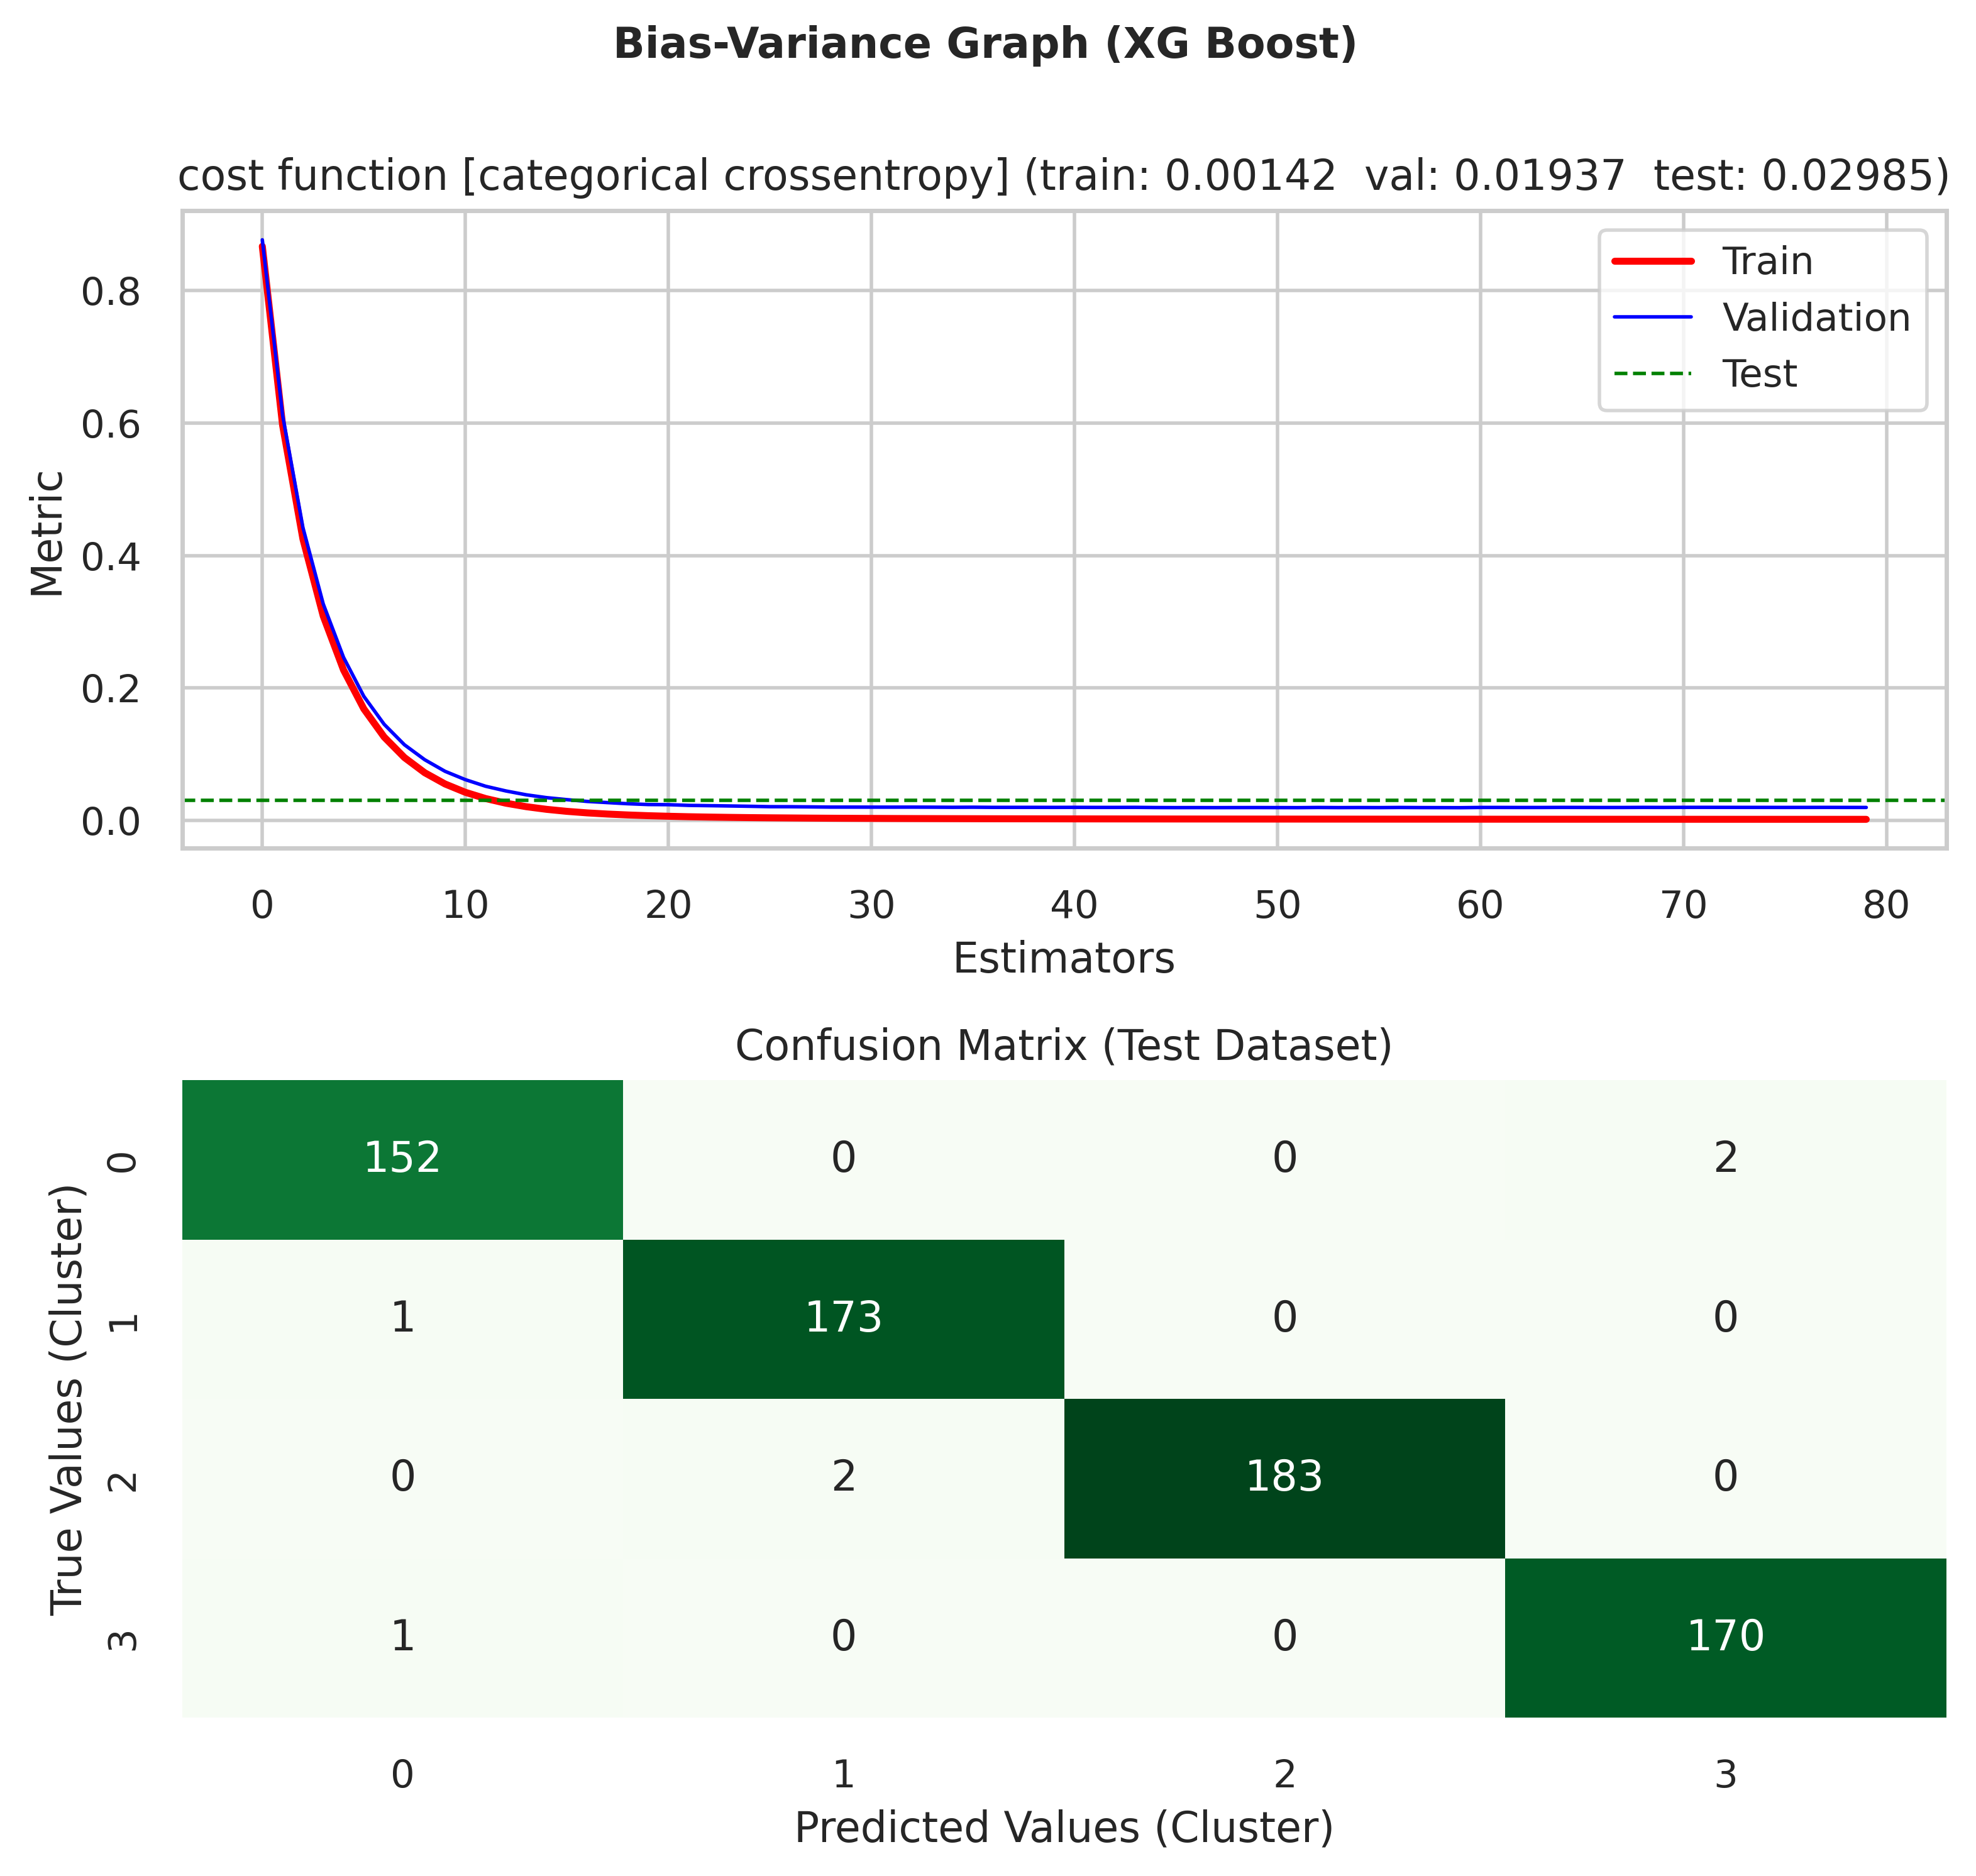

In [69]:
history_xgb_nav_class = xgb_nav_class.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [70]:
end_time_8 = time()

In [71]:
start_time_9 = time()

In [72]:
pred_xgb_nav_class = xgb_nav_class.predict(sample_nav_class)

Inference time: 457.29 milliseconds (10 register(s))


In [73]:
pred_xgb_nav_class

speed      altitude  fuel_consumed  Cluster  \
1073  512.880000  19300.070000    1231.480754        3   
1190  351.590000  28240.070000    1043.825566        1   
795   540.770000  21202.050000    1255.624489        3   
144   384.600000  16115.130000    1054.241564        0   
4188  426.526659  34374.294725    1010.547955        1   
1593  383.950000  27983.640000     980.763574        1   
4565  480.230483  11335.484056    1532.442804        3   
3728  468.260000  20481.730000    1103.749413        0   
4122  414.375847  13371.317435    1203.738408        0   
4203  383.275647  32958.248206    1076.864737        1   

     Cluster (XGB prediction)  
1073                        3  
1190                        1  
795                         3  
144                         0  
4188                        1  
1593                        1  
4565                        3  
3728                        0  
4122                        0  
4203                        1

In [74]:
end_time_9 = time()

In [75]:
print(f"Tempo de Treinamento: {end_time_8 - start_time_8}")

Tempo de Treinamento: 573.3088593482971


In [76]:
print(f"Tempo de Inferência: {end_time_9 - start_time_9}")

Tempo de Inferência: 0.5067505836486816
